#  Data Prep & Filtering

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from functools import reduce
import random

In [2]:

file1 = "Data1.csv"
file2 = "Data2.csv"


In [3]:
def pre_process_df(filename):
    if filename:
        df = pd.read_csv(filename)
        df = df.drop_duplicates()
        df = df[df.brand.notnull()]
        return df[df.price > 0]
    return None
  
def gen_purchase_count(files):
    df = pd.concat([pre_process_df(f) for f in files])
    df = df.loc[:, ['event_type', 'brand', 'user_id']]
    df['purchase_count'] = [1 if e == 'purchase' else 0 for e in df['event_type']]
    df = df.drop(['event_type'], axis = 1)
    df = df.groupby(['brand', 'user_id']).sum()
    df = df[df.purchase_count != 0]
    return df.reset_index()

In [4]:
purchase_count = gen_purchase_count([file1,file2])

In [5]:
user_id  = np.unique(purchase_count['user_id'])
num_brand_purchased = np.zeros(len(user_id))
for loc, user in enumerate(user_id):
    num_brand_purchased[loc] = np.sum(purchase_count['user_id'] == user)

In [6]:
idx = np.where(num_brand_purchased>=5)

In [7]:
filitered_user_id = user_id[idx]

In [8]:
filtered_data = purchase_count.loc[purchase_count['user_id'].isin(filitered_user_id)]

In [9]:
len(filitered_user_id)

10609

In [10]:
len(np.unique(filtered_data['brand']))

213

In [11]:
# train_val is training dataset
# test is testing dataset
# train_data is training dataset+validation dataset combined
# validation is validation dataset
sf = tc.SFrame(filtered_data)
train_data, test = tc.recommender.util.random_split_by_user(sf, user_id = 'user_id', item_id = 'brand',max_num_users=10609,item_test_proportion= 0.2)
train_val, validation = tc.recommender.util.random_split_by_user(train_data, user_id = 'user_id', item_id = 'brand',max_num_users=10609,item_test_proportion=0.25)

# Popularity Model

In [12]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'
# train model with train_data
pop_model = tc.popularity_recommender.create(train_data, user_id=user_id, item_id=item_id, target=target)

Preparing data set.

Data has 60607 observations with 10608 users and 211 items.

Data prepared in: 0.285747s

60607 observations to process; with 211 unique items.

In [13]:
results = pop_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

recommendations finished on 1000/8185 queries. users per second: 32310.2

recommendations finished on 2000/8185 queries. users per second: 49251.4

recommendations finished on 3000/8185 queries. users per second: 64684.4

recommendations finished on 4000/8185 queries. users per second: 79087.3

recommendations finished on 5000/8185 queries. users per second: 93158.4

recommendations finished on 6000/8185 queries. users per second: 106432

recommendations finished on 7000/8185 queries. users per second: 115571

recommendations finished on 8000/8185 queries. users per second: 123665

In [14]:
col_names =  ['cutoff', 'precision', 'recall'] 
popularity_results  = pd.DataFrame(columns = col_names)
popularity_results['cutoff'] = np.array(results['precision_recall_overall']['cutoff'])
popularity_results['precision'] = np.array(results['precision_recall_overall']['precision'])
popularity_results['recall'] = np.array(results['precision_recall_overall']['recall'])

In [15]:
popularity_results

,cutoff,precision,recall
0,1,0.110202,0.060669
1,2,0.070800,0.077013
2,3,0.070536,0.115873
3,4,0.075351,0.166416
4,5,0.083690,0.230092
5,6,0.077846,0.256981
6,7,0.072572,0.279042
7,8,0.066035,0.289826
8,9,0.059418,0.293504
9,10,0.054429,0.298486


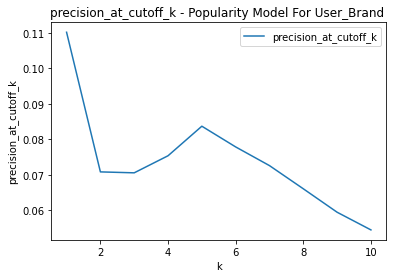

In [16]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'], label = 'precision_at_cutoff_k' )
plt.title('precision_at_cutoff_k - Popularity Model For User_Brand ')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.legend()
plt.show()

#  Item Based CF - Cosine

In [17]:

user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'

In [20]:

test_s_values = np.arange(2,12,2)
def test_s_vals(name):
    s_list = []
    train = []
    val = []
    for loc, s in enumerate(test_s_values):
        model = tc.item_similarity_recommender.create(train_val,similarity_type=name,user_id=user_id, item_id=item_id,target = target,only_top_k=s)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        s_list.append(s)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return s_list,train,val

In [21]:
# hyperparameter tuning for cosine similarity 
cosCF_s, cosCF_train, cosCF_val = test_s_vals('cosine')

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.089493s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.711ms                        | 9.25       |

| 52.989ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 65.287ms                            | 0                | 0               |

| 70.151ms                            | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

PROGRESS: Evaluate model M0


Generating candidate set for working with new users.

Finished training in 1.1112s

recommendations finished on 1000/10559 queries. users per second: 96339.1

recommendations finished on 2000/10559 queries. users per second: 99393.7

recommendations finished on 3000/10559 queries. users per second: 93788.1

recommendations finished on 4000/10559 queries. users per second: 78970.2

recommendations finished on 5000/10559 queries. users per second: 78660.9

recommendations finished on 6000/10559 queries. users per second: 70693

recommendations finished on 7000/10559 queries. users per second: 69898.6

recommendations finished on 8000/10559 queries. users per second: 71275.2

recommendations finished on 9000/10559 queries. users per second: 74466.3

recommendations finished on 10000/10559 queries. users per second: 73592.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.15863244625438036 | 0.03217220976698382 |
|   2    | 0.20375982574107385 | 0.08739397216728816 |
|   3    | 0.23206111689869616 | 0.15490499808684902 |
|   4    | 0.21985983521166777 | 0.19556566858983324 |
|   5    |  0.207595416232598  | 0.22913684370648332 |
|   6    | 0.18922246424850817 | 0.24940347831011994 |
|   7    |  0.1708224534249722 |  0.2617520933883407 |
|   8    |  0.1553177384221988 | 0.27050307545313873 |
|   9    | 0.14163799181319758 |  0.2764296285645581 |
|   10   | 0.12997442939672305 | 0.28039557905361606 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.846084060636304

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.049685s

Training model from provided data.

PROGRESS: Evaluate model M0

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 782us                          | 9.25       |

| 1.917ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.422ms                             | 0                | 0               |

| 4.808ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.007705s

recommendations finished on 1000/10559 queries. users per second: 137137

recommendations finished on 2000/10559 queries. users per second: 142725

recommendations finished on 3000/10559 queries. users per second: 137912

recommendations finished on 4000/10559 queries. users per second: 134721

recommendations finished on 5000/10559 queries. users per second: 130069

recommendations finished on 6000/10559 queries. users per second: 130435

recommendations finished on 7000/10559 queries. users per second: 135554

recommendations finished on 8000/10559 queries. users per second: 140203

recommendations finished on 9000/10559 queries. users per second: 140141

recommendations finished on 10000/10559 queries. users per second: 131053


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.15332891372289056 | 0.030473104923641827 |
|   2    |  0.1802727531016195 | 0.07346324513712799  |
|   3    | 0.19357893739937465 | 0.12222609357822545  |
|   4    | 0.20435173785396327 |  0.1756091835282934  |
|   5    | 0.21778577516810355 |  0.2410306583861556  |
|   6    | 0.20847933832117976 |  0.2781002647880851  |
|   7    | 0.19766482215577777 |  0.3090025058010745  |
|   8    |  0.1877071692395113 | 0.33480076275492465  |
|   9    |  0.1766370973682267 |  0.3536481023113738  |
|   10   | 0.16601950942324104 |  0.3679861335411008  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.8237823289901653

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.042134s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 782us                          | 9.25       |

| 2.067ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.652ms                             | 0                | 0               |

| 5.932ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.012853s

recommendations finished on 1000/10559 queries. users per second: 142430

recommendations finished on 2000/10559 queries. users per second: 139548

recommendations finished on 3000/10559 queries. users per second: 130747

recommendations finished on 4000/10559 queries. users per second: 135575

recommendations finished on 5000/10559 queries. users per second: 140909

recommendations finished on 6000/10559 queries. users per second: 140968

recommendations finished on 7000/10559 queries. users per second: 143634

recommendations finished on 8000/10559 queries. users per second: 147893

recommendations finished on 9000/10559 queries. users per second: 149616

recommendations finished on 10000/10559 queries. users per second: 152462


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.13476654986267644 | 0.026633836849653397 |
|   2    | 0.15830097547116204 |  0.0632675273897955  |
|   3    | 0.17460618114089094 | 0.10740207609847245  |
|   4    | 0.19005114120655353 | 0.16002286494216414  |
|   5    | 0.19545411497300882 | 0.20835809050463536  |
|   6    | 0.19381570224453112 | 0.24947230441072374  |
|   7    | 0.20268423687308007 | 0.31163965868061866  |
|   8    | 0.19533099725352776 |  0.3470408987595219  |
|   9    |  0.1866022666287844 |  0.3756993864785824  |
|   10   |  0.1778009281181929 |  0.3972495973586921  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.8100643291983265

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.04461s

Training model from provided data.

Gathering per-item and per-user statistics.

PROGRESS: Evaluate model M0

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 716us                          | 9.25       |

| 1.743ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.054ms                             | 0                | 0               |

| 6.953ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.012106s

recommendations finished on 1000/10559 queries. users per second: 78131.1

recommendations finished on 2000/10559 queries. users per second: 104428

recommendations finished on 3000/10559 queries. users per second: 115513

recommendations finished on 4000/10559 queries. users per second: 120569

recommendations finished on 5000/10559 queries. users per second: 121930

recommendations finished on 6000/10559 queries. users per second: 116171

recommendations finished on 7000/10559 queries. users per second: 117887

recommendations finished on 8000/10559 queries. users per second: 118545

recommendations finished on 9000/10559 queries. users per second: 122065

recommendations finished on 10000/10559 queries. users per second: 123452


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.12614830949900568 | 0.024821692242556273 |
|   2    | 0.14243773084572411 | 0.05645354105833585  |
|   3    | 0.15276067809451652 | 0.09171218815742445  |
|   4    | 0.16346244909555852 | 0.13227971652547507  |
|   5    | 0.17482716166303694 |  0.1816882276571046  |
|   6    | 0.18099883196009733 |  0.2302350643254047  |
|   7    |  0.1808477534398552 |  0.2697477229222004  |
|   8    | 0.17733686902168758 | 0.30373409441592414  |
|   9    | 0.18438193852532375 | 0.36379953678107724  |
|   10   | 0.17971398806705163 |  0.3984131955184113  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.8024409813381057

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.050771s

Training model from provided data.

Gathering per-item and per-user statistics.

PROGRESS: Evaluate model M0


+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 567us                          | 9.25       |

| 1.863ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.561ms                             | 0                | 0               |

| 7.152ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.014839s

recommendations finished on 1000/10559 queries. users per second: 120846

recommendations finished on 2000/10559 queries. users per second: 120279

recommendations finished on 3000/10559 queries. users per second: 111719

recommendations finished on 4000/10559 queries. users per second: 111641

recommendations finished on 5000/10559 queries. users per second: 119852

recommendations finished on 6000/10559 queries. users per second: 121902

recommendations finished on 7000/10559 queries. users per second: 125606

recommendations finished on 8000/10559 queries. users per second: 128878

recommendations finished on 9000/10559 queries. users per second: 132792

recommendations finished on 10000/10559 queries. users per second: 131258


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.12018183540107974 | 0.02372467679019506 |
|   2    | 0.13268301922530543 | 0.05261705097078036 |
|   3    |  0.1403226315623321 | 0.08347305577419696 |
|   4    | 0.14968273510749144 | 0.11946877078840862 |
|   5    | 0.15842409319064296 |  0.159872576669239  |
|   6    | 0.16399911607791182 | 0.20262248506375838 |
|   7    | 0.16630362723742775 |  0.2429396865002031 |
|   8    |  0.1668600246235437 |  0.2816134171331064 |
|   9    | 0.16789258242047295 |  0.321574853087422  |
|   10   | 0.16608580357988464 |  0.3561088457984624 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.79724562383702

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+---

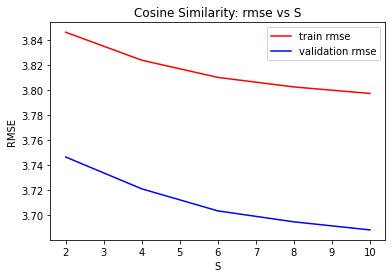

In [22]:
plt.plot(cosCF_s,cosCF_train, color= 'r' ,label='train rmse' )
plt.plot(cosCF_s,cosCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Cosine Similarity: rmse vs S')
plt.legend()
plt.show()

In [23]:
cosCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='cosine',user_id=user_id, item_id=item_id,target = target,only_top_k=10)

Preparing data set.

Data has 60607 observations with 10608 users and 211 items.

Data prepared in: 0.078311s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

In [24]:
cosCF_evaluation = cosCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

+--------------------------------+------------+

| 633us                          | 9.25       |

| 2.032ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.898ms                             | 0                | 0               |

| 17.054ms                            | 100              | 211             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.025486s

recommendations finished on 1000/8185 queries. users per second: 104690

recommendations finished on 2000/8185 queries. users per second: 150083

recommendations finished on 3000/8185 queries. users per second: 175829

recommendations finished on 4000/8185 queries. users per second: 206058

recommendations finished on 5000/8185 queries. users per second: 233995

recommendations finished on 6000/8185 queries. users per second: 249979

recommendations finished on 7000/8185 queries. users per second: 240442

recommendations finished on 8000/8185 queries. users per second: 232924

In [25]:
col_names =  ['cutoff', 'precision', 'recall'] 
cosCF_results  = pd.DataFrame(columns = col_names)
cosCF_results['cutoff'] = np.array(cosCF_evaluation['precision_recall_overall']['cutoff'])
cosCF_results['precision'] = np.array(cosCF_evaluation['precision_recall_overall']['precision'])
cosCF_results['recall'] = np.array(cosCF_evaluation['precision_recall_overall']['recall'])

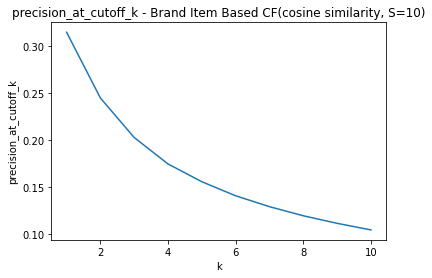

In [26]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('precision_at_cutoff_k - Brand Item Based CF(cosine similarity, S=10)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()

# Item Based CF - Pearson

In [27]:
PearsonCF_s, PearsonCF_train, PearsonCF_val = test_s_vals('pearson')

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.059914s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| 3.989ms                        | 9.25       |

| 7.448ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 19.639ms                            | 0                | 0               |

| 26.486ms                            | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.046326s

recommendations finished on 1000/10559 queries. users per second: 116198

recommendations finished on 2000/10559 queries. users per second: 126687

recommendations finished on 3000/10559 queries. users per second: 126172

recommendations finished on 4000/10559 queries. users per second: 137594

recommendations finished on 5000/10559 queries. users per second: 130202

recommendations finished on 6000/10559 queries. users per second: 130234

recommendations finished on 7000/10559 queries. users per second: 131832

recommendations finished on 8000/10559 queries. users per second: 133320

recommendations finished on 9000/10559 queries. users per second: 125885

recommendations finished on 10000/10559 queries. users per second: 129032


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.00018941187612463305 | 3.077942987025293e-05 |
|   2    |  0.11625153897149343   |  0.05434725962314645  |
|   3    |  0.08340436278688053   |  0.05844903986110469  |
|   4    |  0.10647315086655933   |  0.10109925818871981  |
|   5    |  0.09915711715124569   |  0.11586449412268282  |
|   6    |  0.14529469331060416   |  0.21075175371731256  |
|   7    |  0.13947478792634596   |  0.23383635318935325  |
|   8    |  0.12719007481769115   |  0.24357562660653226  |
|   9    |  0.13340909808378357   |  0.28702063987189586  |
|   10   |  0.12165924803485187   |   0.2910156711181436  |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.0213137757071453

Per User RMSE (best)
+-----------+------+-------+
|

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.04486s

Training model from provided data.

PROGRESS: Evaluate model M0


Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 896us                          | 9.25       |

| 2.887ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.638ms                             | 0                | 0               |

| 7.677ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.013479s

recommendations finished on 1000/10559 queries. users per second: 103702

recommendations finished on 2000/10559 queries. users per second: 118596

recommendations finished on 3000/10559 queries. users per second: 119527

recommendations finished on 4000/10559 queries. users per second: 125849

recommendations finished on 5000/10559 queries. users per second: 134713

recommendations finished on 6000/10559 queries. users per second: 138115

recommendations finished on 7000/10559 queries. users per second: 143299

recommendations finished on 8000/10559 queries. users per second: 146986

recommendations finished on 9000/10559 queries. users per second: 150956

recommendations finished on 10000/10559 queries. users per second: 150871


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0002841178141869499 | 4.2617672128042413e-05 |
|   2    |  0.11596742115730663  |  0.05425018603663244   |
|   3    |  0.08450926539760736  |  0.05914231670979401   |
|   4    |  0.10678094516526186  |  0.10085755818023326   |
|   5    |  0.10396817880481136  |  0.12097003142823894   |
|   6    |  0.14546832086371803  |  0.21104117055422428   |
|   7    |   0.1389336111374185  |   0.2330435223605353   |
|   8    |  0.12844492849701636  |  0.24801328310877852   |
|   9    |  0.13167282255264087  |   0.2835926573147354   |
|   10   |  0.12131830665782736  |   0.2900546313371403   |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 3.01746891938191

Per User RMSE (best)
+-----------+------+-------+
|  

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.039858s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

PROGRESS: Evaluate model M0


+--------------------------------+------------+

| 930us                          | 9.25       |

| 3.249ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.392ms                             | 0                | 0               |

| 10.635ms                            | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.020094s

recommendations finished on 1000/10559 queries. users per second: 123305

recommendations finished on 2000/10559 queries. users per second: 132846

recommendations finished on 3000/10559 queries. users per second: 132025

recommendations finished on 4000/10559 queries. users per second: 145608

recommendations finished on 5000/10559 queries. users per second: 144492

recommendations finished on 6000/10559 queries. users per second: 140151

recommendations finished on 7000/10559 queries. users per second: 146794

recommendations finished on 8000/10559 queries. users per second: 149087

recommendations finished on 9000/10559 queries. users per second: 154044

recommendations finished on 10000/10559 queries. users per second: 154531


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.00028411781418694965 | 4.261767212804243e-05 |
|   2    |   0.1160147741263379   |  0.054230455632869524 |
|   3    |  0.08482495185781518   |  0.05943049334989791  |
|   4    |  0.10732550430912013   |  0.10130590575188808  |
|   5    |  0.10544559143858334   |   0.1225944705893765  |
|   6    |   0.1456419484168323   |  0.21133021499044205  |
|   7    |  0.13902831707548097   |  0.23324128079534187  |
|   8    |  0.12921441424377325   |  0.24922149787178055  |
|   9    |  0.13146236491250265   |  0.28332845781291915  |
|   10   |  0.12116677715692738   |  0.28956858693358456  |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.016453921289529

Per User RMSE (best)
+-----------+------+-------+
| 

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.039219s

Training model from provided data.

Gathering per-item and per-user statistics.

PROGRESS: Evaluate model M0

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 597us                          | 9.25       |

| 2.413ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.914ms                             | 0                | 0               |

| 8.164ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.013883s

recommendations finished on 1000/10559 queries. users per second: 55041.8

recommendations finished on 2000/10559 queries. users per second: 76455.5

recommendations finished on 3000/10559 queries. users per second: 87206.8

recommendations finished on 4000/10559 queries. users per second: 100743

recommendations finished on 5000/10559 queries. users per second: 106580

recommendations finished on 6000/10559 queries. users per second: 109802

recommendations finished on 7000/10559 queries. users per second: 117170

recommendations finished on 8000/10559 queries. users per second: 120751

recommendations finished on 9000/10559 queries. users per second: 122143

recommendations finished on 10000/10559 queries. users per second: 119917


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00028411781418694976 | 4.2617672128042366e-05 |
|   2    |   0.1159674211573066   |  0.054198886986848716  |
|   3    |   0.0850775010259813   |  0.059549664988626336  |
|   4    |  0.10730182782460455   |  0.10130669496803862   |
|   5    |  0.10576759162799514   |  0.12304996105339076   |
|   6    |  0.14565773273984234   |  0.21134599931345224   |
|   7    |  0.13875772868101674   |  0.23280431812000468   |
|   8    |  0.12911970830571082   |   0.2491536252828358   |
|   9    |   0.1314202733844753   |   0.283225859713351    |
|   10   |   0.1212141301259588   |   0.2896404056032818   |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 3.0158818218169126

Per User RMSE (best)
+-----------+---

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.041666s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 955us                          | 9.25       |

| 2.687ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.345ms                             | 0                | 0               |

| 9.305ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.014261s

recommendations finished on 1000/10559 queries. users per second: 108120

recommendations finished on 2000/10559 queries. users per second: 107631

recommendations finished on 3000/10559 queries. users per second: 100385

recommendations finished on 4000/10559 queries. users per second: 113446

recommendations finished on 5000/10559 queries. users per second: 116765

recommendations finished on 6000/10559 queries. users per second: 119339

recommendations finished on 7000/10559 queries. users per second: 115850

recommendations finished on 8000/10559 queries. users per second: 120174

recommendations finished on 9000/10559 queries. users per second: 114119

recommendations finished on 10000/10559 queries. users per second: 119544


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.00028411781418694976 | 4.261767212804247e-05 |
|   2    |  0.11601477412633772   |  0.054217828174461184 |
|   3    |  0.08649809009691613   |  0.06046680931897259  |
|   4    |  0.10734918079363576   |   0.1014759688232675  |
|   5    |  0.10622218013069447   |  0.12518279890930878  |
|   6    |  0.14565773273984248   |  0.21130732772207686  |
|   7    |  0.13882537577963303   |   0.2328902709334882  |
|   8    |   0.1292262524860309   |  0.24946615487844134  |
|   9    |   0.131399227620461    |  0.28318639890582525  |
|   10   |  0.12124254190737745   |  0.28965145462938924  |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.0156504584385404

Per User RMSE (best)
+-----------+------+-------+
|

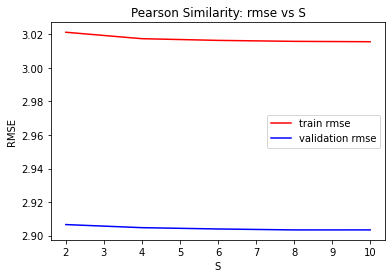

In [28]:
plt.plot(PearsonCF_s,PearsonCF_train, color= 'r' ,label='train rmse' )
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

In [29]:
PearsonCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='pearson',user_id=user_id, item_id=item_id,target = target,only_top_k=10)

Preparing data set.

Data has 60607 observations with 10608 users and 211 items.

Data prepared in: 0.068018s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

In [30]:
PearsonCF_evaluation = PearsonCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

+--------------------------------+------------+

| 819us                          | 9.25       |

| 3.579ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.877ms                             | 0                | 0               |

| 16.378ms                            | 100              | 211             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.024859s

recommendations finished on 1000/8185 queries. users per second: 106090

recommendations finished on 2000/8185 queries. users per second: 165618

recommendations finished on 3000/8185 queries. users per second: 201952

recommendations finished on 4000/8185 queries. users per second: 225238

recommendations finished on 5000/8185 queries. users per second: 239693

recommendations finished on 6000/8185 queries. users per second: 256421

recommendations finished on 7000/8185 queries. users per second: 259288

recommendations finished on 8000/8185 queries. users per second: 245226

In [31]:
col_names =  ['cutoff', 'precision', 'recall'] 
PearsonCF_results  = pd.DataFrame(columns = col_names)
PearsonCF_results['cutoff'] = np.array(PearsonCF_evaluation['precision_recall_overall']['cutoff'])
PearsonCF_results['precision'] = np.array(PearsonCF_evaluation['precision_recall_overall']['precision'])
PearsonCF_results['recall'] = np.array(PearsonCF_evaluation['precision_recall_overall']['recall'])

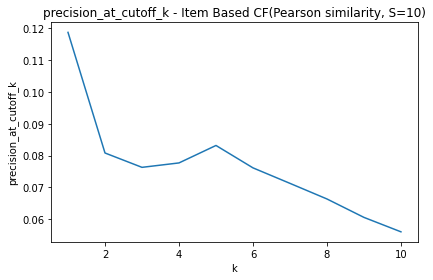

In [32]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('precision_at_cutoff_k - Item Based CF(Pearson similarity, S=10)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.tight_layout()
plt.show()

# Item Based CF - Jaccard

In [33]:
JaccardCF_s, JaccardCF_train, JaccardCF_val = test_s_vals('jaccard')

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.103872s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| 800us                          | 9.25       |

| 6.016ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.433ms                            | 0                | 0               |

| 25.95ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.030837s

recommendations finished on 1000/10559 queries. users per second: 61549.8

recommendations finished on 2000/10559 queries. users per second: 94966.8

recommendations finished on 3000/10559 queries. users per second: 112537

recommendations finished on 4000/10559 queries. users per second: 120934

recommendations finished on 5000/10559 queries. users per second: 118802

recommendations finished on 6000/10559 queries. users per second: 111765

recommendations finished on 7000/10559 queries. users per second: 111027

recommendations finished on 8000/10559 queries. users per second: 113737

recommendations finished on 9000/10559 queries. users per second: 116042

recommendations finished on 10000/10559 queries. users per second: 112736


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.17018657069798274 | 0.033614302595446816 |
|   2    | 0.24495690879818183 | 0.10277082201549755  |
|   3    |  0.2927044859045997 |  0.198022400447774   |
|   4    | 0.27509707358651403 | 0.24604862630807522  |
|   5    |  0.2438299081352398 | 0.26905813954495067  |
|   6    | 0.21551914638381123 | 0.28280977840562593  |
|   7    | 0.19320011364712553 | 0.29776547136480624  |
|   8    | 0.17363149919499976 |  0.304488868042519   |
|   9    | 0.15816943944607578 |  0.3122432501732753  |
|   10   | 0.14602708589828564 |  0.320612542902007   |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.886097794041905

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.043628s

Training model from provided data.

PROGRESS: Evaluate model M0


Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 735us                          | 9.25       |

| 1.978ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.538ms                             | 0                | 0               |

| 5.42ms                              | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.008836s

recommendations finished on 1000/10559 queries. users per second: 91962.5

recommendations finished on 2000/10559 queries. users per second: 112296

recommendations finished on 3000/10559 queries. users per second: 123696

recommendations finished on 4000/10559 queries. users per second: 121179

recommendations finished on 5000/10559 queries. users per second: 124496

recommendations finished on 6000/10559 queries. users per second: 132658

recommendations finished on 7000/10559 queries. users per second: 131094

recommendations finished on 8000/10559 queries. users per second: 135197

recommendations finished on 9000/10559 queries. users per second: 135573

recommendations finished on 10000/10559 queries. users per second: 134383


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.09158064210625995 |  0.0166269888611576  |
|   2    |  0.1500615588597407 | 0.057560608569406355 |
|   3    | 0.18193010701771004 | 0.10770249019213932  |
|   4    |  0.230537929728194  | 0.19577990381487753  |
|   5    | 0.26856709915711724 | 0.30302763843181885  |
|   6    |  0.2509707358651396 |  0.340132382575581   |
|   7    |  0.2329901370530223 | 0.36717184820192234  |
|   8    | 0.21829718723363947 |  0.3891361038676597  |
|   9    | 0.20283907356546785 |  0.4064115604710658  |
|   10   |  0.1893550525617956 | 0.41963321724823294  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.8801302890942666

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.039876s

Training model from provided data.

PROGRESS: Evaluate model M0


Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 681us                          | 9.25       |

| 1.671ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.283ms                             | 0                | 0               |

| 4.683ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.008986s

recommendations finished on 1000/10559 queries. users per second: 122895

recommendations finished on 2000/10559 queries. users per second: 133941

recommendations finished on 3000/10559 queries. users per second: 132380

recommendations finished on 4000/10559 queries. users per second: 130523

recommendations finished on 5000/10559 queries. users per second: 128846

recommendations finished on 6000/10559 queries. users per second: 128254

recommendations finished on 7000/10559 queries. users per second: 133805

recommendations finished on 8000/10559 queries. users per second: 132879

recommendations finished on 9000/10559 queries. users per second: 138139

recommendations finished on 10000/10559 queries. users per second: 141433


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.06421062600625059 | 0.01092513344578771 |
|   2    | 0.09759446917321718 | 0.03476118735660273 |
|   3    | 0.12861066388862585 | 0.07185891780817548 |
|   4    | 0.17051804148120092 | 0.13229078781659737 |
|   5    | 0.21066388862581745 | 0.22051438324938866 |
|   6    | 0.23616504088139698 |  0.3112452763872451 |
|   7    | 0.24086425933191707 | 0.37938400093963576 |
|   8    | 0.22819395776115145 |  0.4122639387444084 |
|   9    | 0.21558228367585325 | 0.43780853371277306 |
|   10   | 0.20376929633488014 | 0.45740485840593376 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.876140348689498

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.038192s

Training model from provided data.

PROGRESS: Evaluate model M0


Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.011ms                        | 9.25       |

| 2.303ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.099ms                             | 0                | 0               |

| 5.074ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.010592s

recommendations finished on 1000/10559 queries. users per second: 116809

recommendations finished on 2000/10559 queries. users per second: 132398

recommendations finished on 3000/10559 queries. users per second: 132363

recommendations finished on 4000/10559 queries. users per second: 143503

recommendations finished on 5000/10559 queries. users per second: 134405

recommendations finished on 6000/10559 queries. users per second: 132917

recommendations finished on 7000/10559 queries. users per second: 135010

recommendations finished on 8000/10559 queries. users per second: 138207

recommendations finished on 9000/10559 queries. users per second: 143123

recommendations finished on 10000/10559 queries. users per second: 143575


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.06222180130694196 | 0.010307440271981272 |
|   2    |  0.0946585850932854 | 0.033493554485180585 |
|   3    | 0.10919594658585095 | 0.05960096201377535  |
|   4    | 0.12541433847902284 | 0.09416974290974708  |
|   5    | 0.14874514632067487 | 0.14405969507365707  |
|   6    | 0.18516589323483912 | 0.22577502823824033  |
|   7    | 0.21165424214955364 |  0.3150455055841809  |
|   8    |  0.2167227010133536 |  0.380094720481448   |
|   9    | 0.21556123791183868 | 0.43621885347768125  |
|   10   | 0.20731129841841053 |  0.4686270326976525  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.873833868508914

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.05411s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 563us                          | 9.25       |

| 1.909ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.353ms                             | 0                | 0               |

| 6.316ms                             | 100              | 205             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.01205s

recommendations finished on 1000/10559 queries. users per second: 111932

recommendations finished on 2000/10559 queries. users per second: 124123

recommendations finished on 3000/10559 queries. users per second: 110181

recommendations finished on 4000/10559 queries. users per second: 80635.4

recommendations finished on 5000/10559 queries. users per second: 89847.3

recommendations finished on 6000/10559 queries. users per second: 92479.8

recommendations finished on 7000/10559 queries. users per second: 98730.6

recommendations finished on 8000/10559 queries. users per second: 104316

recommendations finished on 9000/10559 queries. users per second: 109721

recommendations finished on 10000/10559 queries. users per second: 110494


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.05824415190832465 | 0.009608617004315154 |
|   2    |  0.0915806421062601 | 0.032368515863275604 |
|   3    | 0.10818574991318626 | 0.059098911992064816 |
|   4    | 0.12340183729519837 | 0.09242185462667553  |
|   5    |  0.1387441992612937 | 0.13306884253649331  |
|   6    | 0.15725921015247685 |  0.1852757083633816  |
|   7    | 0.17488127934192887 | 0.24651609063842558  |
|   8    | 0.18448716734539256 | 0.30481924912993663  |
|   9    | 0.19417874167376958 |  0.3760728896416114  |
|   10   |  0.2018846481674402 | 0.44616636176712327  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.872428617162322

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

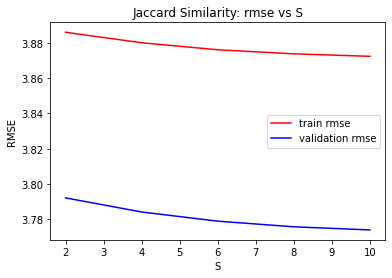

In [57]:
plt.plot(JaccardCF_s,JaccardCF_train, color= 'r' ,label='train rmse' )
plt.plot(JaccardCF_s,JaccardCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Jaccard Similarity: rmse vs S')
plt.legend()
plt.show()

In [35]:
JaccardCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='jaccard',user_id=user_id, item_id=item_id,target = target,only_top_k=10)

Preparing data set.

Data has 60607 observations with 10608 users and 211 items.

Data prepared in: 0.056141s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

In [36]:
JaccardCF_evaluation = JaccardCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

| 1.091ms                        | 9.25       |

| 2.879ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.909ms                             | 0                | 0               |

| 10.863ms                            | 100              | 211             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.021686s

recommendations finished on 1000/8185 queries. users per second: 192938

recommendations finished on 2000/8185 queries. users per second: 259000

recommendations finished on 3000/8185 queries. users per second: 262973

recommendations finished on 4000/8185 queries. users per second: 265358

recommendations finished on 5000/8185 queries. users per second: 204599

recommendations finished on 6000/8185 queries. users per second: 220629

recommendations finished on 7000/8185 queries. users per second: 233512

recommendations finished on 8000/8185 queries. users per second: 211182

In [37]:
col_names =  ['cutoff', 'precision', 'recall'] 
JaccardCF_results  = pd.DataFrame(columns = col_names)
JaccardCF_results['cutoff'] = np.array(JaccardCF_evaluation['precision_recall_overall']['cutoff'])
JaccardCF_results['precision'] = np.array(JaccardCF_evaluation['precision_recall_overall']['precision'])
JaccardCF_results['recall'] = np.array(JaccardCF_evaluation['precision_recall_overall']['recall'])

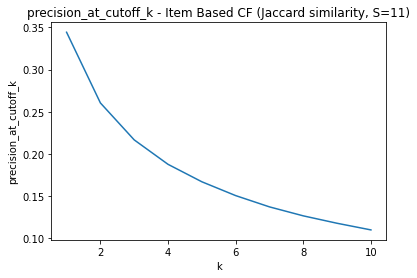

In [38]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('precision_at_cutoff_k - Item Based CF (Jaccard similarity, S=11)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()

# Matrix Factorization iALS


In [39]:

user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'

In [40]:

num_features = np.arange(1,11,2)
def test_k_vals():
    k_list = []
    train = []
    val = []
    for loc, k in enumerate(num_features):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = k)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        k_list.append(k)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return k_list,train,val

In [41]:
ials_k, ials_train_k, ials_val_k = test_k_vals() 

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.080058s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 1        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 104us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 26.08ms      | 3.85366                   |

| 1       | 43.066ms     | 3.77726                   |

| 2       | 73.747ms     | 3.7312                    |

| 3       | 93.348ms     | 3.65158                   |

| 4       | 108.814ms    | 3.63853                   |

| 5       | 122.381ms    | 3.63846                   |

| 6       | 136.852ms    | 3.63846                   |

| 7       | 169.626ms    | 3.63847                   |

| 8       | 183.714ms    | 3.63847                   |

| 9       | 195.242ms    | 3.63848                   |

| 10      | 206.625ms    | 3.63848                   |

| 11      | 218.883ms    | 3.63848                   |

| 12      | 231.982ms    | 3.63849                   |

| 13      | 246.174ms    | 3.63849                   |

| 14      | 259.218ms    | 3.63849                   |

| 15      | 276.71ms     | 3.6385                    |

| 16      | 296.921ms    | 3.6385                    |

| 17      | 307.486ms    | 3.6385                    |

| 18      | 320.764ms    | 3.63851                   |

| 19      | 332.803ms    | 3.63851                   |

| 20      | 347.304ms    | 3.63851                   |

| 21      | 361.687ms    | 3.63852                   |

| 22      | 371.221ms    | 3.63852                   |

| 23      | 384.91ms     | 3.63852                   |

| 24      | 398.919ms    | 3.63853                   |

| FINAL   | 398.999ms    | 3.63853                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 38349.4

recommendations finished on 2000/10559 queries. users per second: 60675.9

recommendations finished on 3000/10559 queries. users per second: 72495.3

recommendations finished on 4000/10559 queries. users per second: 81616

recommendations finished on 5000/10559 queries. users per second: 89498.3

recommendations finished on 6000/10559 queries. users per second: 93382.3

recommendations finished on 7000/10559 queries. users per second: 99635.6

recommendations finished on 8000/10559 queries. users per second: 103778

recommendations finished on 9000/10559 queries. users per second: 107175

recommendations finished on 10000/10559 queries. users per second: 108480


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4234302490766172 | 0.10497490742259455 |
|   2    | 0.40922435836726945 | 0.20113829756671073 |
|   3    |  0.3503172648925088 |  0.2556043530113715 |
|   4    |  0.3144473908514062 | 0.30493128255262825 |
|   5    |  0.2865991097641822 | 0.34745387677070755 |
|   6    |  0.2711904536414436 |  0.3924553529213409 |
|   7    | 0.25036191197759533 |  0.4204870667116498 |
|   8    | 0.23533241784259865 |  0.4513599038377951 |
|   9    | 0.22227483663225645 | 0.47767589726880727 |
|   10   | 0.21442371436689114 |  0.510287884056909  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.6385252796298073

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.05328s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 3        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 20.736ms     | 3.76065                   |

| 1       | 34.985ms     | 3.60331                   |

| 2       | 52.968ms     | 3.59838                   |

| 3       | 67.711ms     | 3.59611                   |

| 4       | 83.008ms     | 3.59413                   |

| 5       | 103.109ms    | 3.59269                   |

| 6       | 116.803ms    | 3.59167                   |

| 7       | 133.216ms    | 3.59092                   |

| 8       | 146.557ms    | 3.59035                   |

| 9       | 164.093ms    | 3.58991                   |

| 10      | 178.903ms    | 3.58957                   |

| 11      | 194.955ms    | 3.5893                    |

| 12      | 210.296ms    | 3.58906                   |

| 13      | 227.076ms    | 3.58882                   |

| 14      | 240.526ms    | 3.58862                   |

| 15      | 265.533ms    | 3.58849                   |

| 16      | 280.985ms    | 3.58843                   |

| 17      | 301.265ms    | 3.58842                   |

| 18      | 319.82ms     | 3.58842                   |

| 19      | 331.823ms    | 3.58842                   |

| 20      | 355.787ms    | 3.58842                   |

| 21      | 375.971ms    | 3.58842                   |

| 22      | 394.76ms     | 3.58842                   |

| 23      | 422.602ms    | 3.58841                   |

| 24      | 443.195ms    | 3.58841                   |

| FINAL   | 443.291ms    | 3.58841                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 45886.3

recommendations finished on 2000/10559 queries. users per second: 63435.7

recommendations finished on 3000/10559 queries. users per second: 74041.2

recommendations finished on 4000/10559 queries. users per second: 84774.5

recommendations finished on 5000/10559 queries. users per second: 88074.7

recommendations finished on 6000/10559 queries. users per second: 89823

recommendations finished on 7000/10559 queries. users per second: 92569.3

recommendations finished on 8000/10559 queries. users per second: 94740.7

recommendations finished on 9000/10559 queries. users per second: 95451.2

recommendations finished on 10000/10559 queries. users per second: 92986.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5787479874988162 |  0.1558420246168904 |
|   2    |  0.5331944312908418 | 0.28023236738551727 |
|   3    |  0.4611547810714401 |  0.3534207612550271 |
|   4    |  0.4143621555071502 |  0.417472419450905  |
|   5    | 0.37619092717113445 | 0.46866666764504916 |
|   6    |  0.3434510843829912 |  0.5101045428263578 |
|   7    |  0.3147890086994167 |  0.5424736885763928 |
|   8    |  0.2928189222464252 |  0.5746338310726301 |
|   9    | 0.27334238301185876 |  0.6002190876682851 |
|   10   |  0.2555166208921299 |  0.6207645108938848 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.588409237699973

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.051077s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 5        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 102us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 25.267ms     | 3.66431                   |

| 1       | 45.036ms     | 3.56657                   |

| 2       | 62.731ms     | 3.56441                   |

| 3       | 82.643ms     | 3.56287                   |

| 4       | 102.258ms    | 3.56181                   |

| 5       | 129.471ms    | 3.56105                   |

| 6       | 145.582ms    | 3.56047                   |

| 7       | 163.044ms    | 3.56                      |

| 8       | 186.309ms    | 3.55962                   |

| 9       | 206.787ms    | 3.5593                    |

| 10      | 227.887ms    | 3.55903                   |

| 11      | 244.664ms    | 3.55879                   |

| 12      | 263.542ms    | 3.55858                   |

| 13      | 283.782ms    | 3.5584                    |

| 14      | 301.867ms    | 3.55824                   |

| 15      | 323.28ms     | 3.55811                   |

| 16      | 341.441ms    | 3.558                     |

| 17      | 361.192ms    | 3.55791                   |

| 18      | 382.737ms    | 3.55783                   |

| 19      | 402.03ms     | 3.55778                   |

| 20      | 421.785ms    | 3.55773                   |

| 21      | 443.343ms    | 3.5577                    |

| 22      | 464.306ms    | 3.55768                   |

| 23      | 484.765ms    | 3.55767                   |

| 24      | 524.538ms    | 3.55766                   |

| FINAL   | 524.62ms     | 3.55766                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 48339.5

recommendations finished on 2000/10559 queries. users per second: 65502.9

recommendations finished on 3000/10559 queries. users per second: 73715.5

recommendations finished on 4000/10559 queries. users per second: 78376

recommendations finished on 5000/10559 queries. users per second: 81135.9

recommendations finished on 6000/10559 queries. users per second: 81849.8

recommendations finished on 7000/10559 queries. users per second: 84005.4

recommendations finished on 8000/10559 queries. users per second: 85941.1

recommendations finished on 9000/10559 queries. users per second: 88045.4

recommendations finished on 10000/10559 queries. users per second: 88258.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7394639643905679 | 0.20460118502594016 |
|   2    |  0.6394071408277313 |  0.3371002584033549 |
|   3    |  0.5586703286296045 |  0.4309759738239602 |
|   4    |  0.488303816649304  | 0.49439051242495624 |
|   5    |  0.4324083720049256 |  0.5393110418395867 |
|   6    | 0.38884679736086153 |  0.5780376191528734 |
|   7    |  0.3525360897271106 |  0.6071982053624224 |
|   8    |  0.3238587934463491 |  0.6344608324771932 |
|   9    | 0.29987056855131416 |  0.6582133210264253 |
|   10   | 0.27906998768822794 |  0.6785434362875303 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.55766305629177

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.058515s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 7        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 34.018ms     | 3.63859                   |

| 1       | 57.722ms     | 3.54339                   |

| 2       | 84.941ms     | 3.54012                   |

| 3       | 106.1ms      | 3.53865                   |

| 4       | 124.795ms    | 3.53785                   |

| 5       | 144.971ms    | 3.53737                   |

| 6       | 163.06ms     | 3.53708                   |

| 7       | 185.09ms     | 3.53692                   |

| 8       | 209.051ms    | 3.53682                   |

| 9       | 233.72ms     | 3.53677                   |

| 10      | 267.764ms    | 3.53674                   |

| 11      | 291.956ms    | 3.53672                   |

| 12      | 319.294ms    | 3.53671                   |

| 13      | 361.331ms    | 3.53671                   |

| 14      | 387.953ms    | 3.53671                   |

| 15      | 418.678ms    | 3.53671                   |

| 16      | 444.736ms    | 3.53671                   |

| 17      | 466.475ms    | 3.53672                   |

| 18      | 492.911ms    | 3.53672                   |

| 19      | 519.925ms    | 3.53673                   |

| 20      | 566.659ms    | 3.53674                   |

| 21      | 592.816ms    | 3.53675                   |

| 22      | 625.877ms    | 3.53676                   |

| 23      | 650.288ms    | 3.53677                   |

| 24      | 678.536ms    | 3.53677                   |

| FINAL   | 678.624ms    | 3.53677                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 80938.9

recommendations finished on 2000/10559 queries. users per second: 88331.4

recommendations finished on 3000/10559 queries. users per second: 89909.2

recommendations finished on 4000/10559 queries. users per second: 92470.6

recommendations finished on 5000/10559 queries. users per second: 95480

recommendations finished on 6000/10559 queries. users per second: 97317.3

recommendations finished on 7000/10559 queries. users per second: 97118.4

recommendations finished on 8000/10559 queries. users per second: 97311.8

recommendations finished on 9000/10559 queries. users per second: 98249

recommendations finished on 10000/10559 queries. users per second: 99626.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.838810493417937  | 0.23482410928162423 |
|   2    |  0.7399374940808789 | 0.39547161970823286 |
|   3    |  0.6333933137607731 |  0.491752219129056  |
|   4    |  0.5470214982479398 |  0.5572243787005744 |
|   5    |  0.4794772232218957 |  0.6009719770696537 |
|   6    |  0.425908387789248  |  0.6337252933718366 |
|   7    | 0.38244963673508053 |  0.6586710867274046 |
|   8    |  0.3480206458944981 |  0.6812370988186486 |
|   9    | 0.32037966558281045 |  0.7026994507741929 |
|   10   |  0.2969788805758121 |  0.7211415595156271 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.536774491263529

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.0515s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 9        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 112us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 34.224ms     | 3.59536                   |

| 1       | 65.098ms     | 3.52533                   |

| 2       | 96.941ms     | 3.52109                   |

| 3       | 130.933ms    | 3.51941                   |

| 4       | 160.344ms    | 3.51864                   |

| 5       | 185.418ms    | 3.51832                   |

| 6       | 215.199ms    | 3.51819                   |

| 7       | 245.874ms    | 3.51814                   |

| 8       | 274.474ms    | 3.51815                   |

| 9       | 299.817ms    | 3.51819                   |

| 10      | 326.733ms    | 3.51824                   |

| 11      | 354.233ms    | 3.5183                    |

| 12      | 381.342ms    | 3.51836                   |

| 13      | 407.607ms    | 3.51841                   |

| 14      | 437.307ms    | 3.51846                   |

| 15      | 466.389ms    | 3.51851                   |

| 16      | 492.488ms    | 3.51855                   |

| 17      | 517.544ms    | 3.51859                   |

| 18      | 548.758ms    | 3.51862                   |

| 19      | 575.93ms     | 3.51865                   |

| 20      | 603.919ms    | 3.51868                   |

| 21      | 640.502ms    | 3.5187                    |

| 22      | 669.905ms    | 3.51872                   |

| 23      | 697.528ms    | 3.51874                   |

| 24      | 730.671ms    | 3.51876                   |

| FINAL   | 730.77ms     | 3.51876                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 43346.3

recommendations finished on 2000/10559 queries. users per second: 62879.2

recommendations finished on 3000/10559 queries. users per second: 73371.2

recommendations finished on 4000/10559 queries. users per second: 80208.5

recommendations finished on 5000/10559 queries. users per second: 83610.6

recommendations finished on 6000/10559 queries. users per second: 87130.8

recommendations finished on 7000/10559 queries. users per second: 91162.5

recommendations finished on 8000/10559 queries. users per second: 96086.9

recommendations finished on 9000/10559 queries. users per second: 97959.2

recommendations finished on 10000/10559 queries. users per second: 97163.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.8905199355999625 |  0.2530835889952454 |
|   2    |  0.7927360545506212 | 0.42935665757447117 |
|   3    |  0.6901853079521431 |   0.54000071814852  |
|   4    |  0.5963632919784059 |  0.6074863127573068 |
|   5    |  0.5223979543517377 |  0.6539215580807739 |
|   6    |  0.4622912523281878 |  0.6864667129417361 |
|   7    |  0.4143790672818046 |  0.7116241438097669 |
|   8    |  0.3759115446538496 |  0.7331547103077268 |
|   9    |  0.3436036661720915 |  0.750087252226314  |
|   10   | 0.31642200966000555 |  0.7644977321722427 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5187565228249595

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

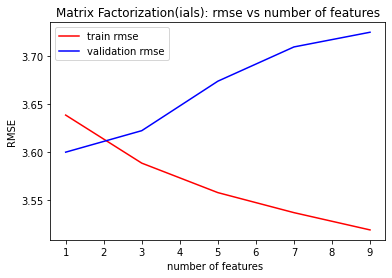

In [42]:

plt.plot(ials_k, ials_train_k, color= 'r' ,label='train rmse' )
plt.plot(ials_k,  ials_val_k, color= 'b',label='validation rmse' )
plt.xlabel('number of features  ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs number of features')
plt.legend()
plt.show()

In [43]:

num_scales = np.arange(1,11,2)
def test_scale_vals():
    scale_list = []
    train = []
    val = []
    for loc, scale in enumerate(num_scales):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials',num_factors = 2,\
                                                                   ials_confidence_scaling_factor = scale)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        scale_list.append(scale)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return scale_list,train,val

In [44]:
ials_scale, ials_train_scale, ials_val_scale = test_scale_vals() 

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.051556s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 98us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 19.01ms      | 3.81017                   |

| 1       | 32.216ms     | 3.7385                    |

| 2       | 46.734ms     | 3.66254                   |

| 3       | 64.133ms     | 3.61751                   |

| 4       | 74.818ms     | 3.61254                   |

| 5       | 89.642ms     | 3.61086                   |

| 6       | 102.401ms    | 3.61005                   |

| 7       | 119.034ms    | 3.60968                   |

| 8       | 129.556ms    | 3.60951                   |

| 9       | 142.145ms    | 3.60943                   |

| 10      | 155.115ms    | 3.60939                   |

| 11      | 169.042ms    | 3.60938                   |

| 12      | 181.482ms    | 3.60939                   |

| 13      | 194.516ms    | 3.6094                    |

| 14      | 206.73ms     | 3.60941                   |

| 15      | 224.203ms    | 3.60943                   |

| 16      | 240.561ms    | 3.60944                   |

| 17      | 252.179ms    | 3.60946                   |

| 18      | 264.132ms    | 3.60947                   |

| 19      | 276.948ms    | 3.60949                   |

| 20      | 290.943ms    | 3.6095                    |

| 21      | 318.903ms    | 3.60952                   |

| 22      | 341.278ms    | 3.60953                   |

| 23      | 353.579ms    | 3.60954                   |

| 24      | 372.696ms    | 3.60955                   |

| FINAL   | 372.775ms    | 3.60955                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 51124.7

recommendations finished on 2000/10559 queries. users per second: 75321.1

recommendations finished on 3000/10559 queries. users per second: 83558.5

recommendations finished on 4000/10559 queries. users per second: 93099

recommendations finished on 5000/10559 queries. users per second: 91561.7

recommendations finished on 6000/10559 queries. users per second: 95183.7

recommendations finished on 7000/10559 queries. users per second: 96768

recommendations finished on 8000/10559 queries. users per second: 97142.8

recommendations finished on 9000/10559 queries. users per second: 99100.4

recommendations finished on 10000/10559 queries. users per second: 100017


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5052561795624568 |  0.1287065548094175 |
|   2    | 0.47892792878113466 | 0.24378410552646912 |
|   3    |  0.406035925119172  | 0.30763215262826293 |
|   4    |  0.3619187423051424 | 0.36153078453025733 |
|   5    |  0.3320579600340947 |  0.4111775505870267 |
|   6    |  0.3110616535656784 |  0.4600896297752423 |
|   7    |  0.2886772286336644 | 0.49396841904001426 |
|   8    | 0.27000662941566433 |  0.5267852615481137 |
|   9    |  0.2543696267533753 |  0.5576683833588801 |
|   10   | 0.23997537645610384 |  0.5827917619995233 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.609554650970854

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.052874s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 20.394ms     | 3.78622                   |

| 1       | 32.4ms       | 3.67855                   |

| 2       | 47.339ms     | 3.60233                   |

| 3       | 60.378ms     | 3.55388                   |

| 4       | 78.282ms     | 3.54877                   |

| 5       | 93.686ms     | 3.54779                   |

| 6       | 106.087ms    | 3.54734                   |

| 7       | 120.088ms    | 3.54686                   |

| 8       | 133.67ms     | 3.54631                   |

| 9       | 147.774ms    | 3.54611                   |

| 10      | 159.807ms    | 3.54604                   |

| 11      | 172.22ms     | 3.54602                   |

| 12      | 197.982ms    | 3.54603                   |

| 13      | 212.02ms     | 3.54604                   |

| 14      | 224.155ms    | 3.54606                   |

| 15      | 235.235ms    | 3.54607                   |

| 16      | 250.373ms    | 3.54608                   |

| 17      | 267.151ms    | 3.54609                   |

| 18      | 279.384ms    | 3.54609                   |

| 19      | 296.757ms    | 3.54609                   |

| 20      | 311.223ms    | 3.54609                   |

| 21      | 329.027ms    | 3.5461                    |

| 22      | 352.663ms    | 3.5461                    |

| 23      | 369.989ms    | 3.5461                    |

| 24      | 384.168ms    | 3.54608                   |

| FINAL   | 384.262ms    | 3.54608                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 84803.3

recommendations finished on 2000/10559 queries. users per second: 99995

recommendations finished on 3000/10559 queries. users per second: 98325.2

recommendations finished on 4000/10559 queries. users per second: 104583

recommendations finished on 5000/10559 queries. users per second: 100579

recommendations finished on 6000/10559 queries. users per second: 98449.4

recommendations finished on 7000/10559 queries. users per second: 97472.7

recommendations finished on 8000/10559 queries. users per second: 96529.8

recommendations finished on 9000/10559 queries. users per second: 100026

recommendations finished on 10000/10559 queries. users per second: 100257


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4744767496922057 | 0.12318957409685662 |
|   2    | 0.44615967421157327 | 0.23071231080394952 |
|   3    |  0.3911039555513459 |  0.2991442071246264 |
|   4    | 0.35680462164977694 |  0.3602096331757901 |
|   5    | 0.32915995832938677 |  0.4100431900342841 |
|   6    | 0.30651576853868684 | 0.45496823123117025 |
|   7    | 0.28583605049179445 | 0.49259280761923546 |
|   8    | 0.26838479022634687 |  0.5260179897599693 |
|   9    |  0.253264724142648  |  0.5558809615236874 |
|   10   | 0.24000378823752222 |  0.5824348162889643 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5460806454897034

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.096963s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 520us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 27.927ms     | 3.7067                    |

| 1       | 54.362ms     | 3.53387                   |

| 2       | 84.3ms       | 3.52077                   |

| 3       | 100.238ms    | 3.51909                   |

| 4       | 167.226ms    | 3.51806                   |

| 5       | 208.681ms    | 3.51753                   |

| 6       | 235.019ms    | 3.51723                   |

| 7       | 258.593ms    | 3.51702                   |

| 8       | 275.3ms      | 3.51682                   |

| 9       | 314.716ms    | 3.51665                   |

| 10      | 329.485ms    | 3.51651                   |

| 11      | 359.605ms    | 3.51634                   |

| 12      | 381.563ms    | 3.51599                   |

| 13      | 397.984ms    | 3.51572                   |

| 14      | 413.442ms    | 3.51563                   |

| 15      | 427.802ms    | 3.51556                   |

| 16      | 448.793ms    | 3.51548                   |

| 17      | 475.943ms    | 3.51538                   |

| 18      | 487.672ms    | 3.51527                   |

| 19      | 501.565ms    | 3.51521                   |

| 20      | 514.675ms    | 3.51521                   |

| 21      | 527.261ms    | 3.51522                   |

| 22      | 546.196ms    | 3.51523                   |

| 23      | 558.052ms    | 3.51525                   |

| 24      | 571.804ms    | 3.51527                   |

| FINAL   | 571.878ms    | 3.51527                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 106383

recommendations finished on 2000/10559 queries. users per second: 115068

recommendations finished on 3000/10559 queries. users per second: 109593

recommendations finished on 4000/10559 queries. users per second: 114613

recommendations finished on 5000/10559 queries. users per second: 114411

recommendations finished on 6000/10559 queries. users per second: 111647

recommendations finished on 7000/10559 queries. users per second: 108488

recommendations finished on 8000/10559 queries. users per second: 106004

recommendations finished on 9000/10559 queries. users per second: 107965

recommendations finished on 10000/10559 queries. users per second: 107694


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.43981437636139814 | 0.11438715447204029 |
|   2    |  0.4227673075101812 | 0.21920296984342946 |
|   3    |  0.3720680620008203 |  0.2857713111977482 |
|   4    |  0.3400653470972631 |  0.3433676144501824 |
|   5    |  0.3166398333175485 |  0.3969639983745416 |
|   6    |  0.297281939577612  | 0.44379932521426774 |
|   7    |  0.278936046432968  | 0.48131326145293213 |
|   8    |  0.2625722132777726 |  0.515571302016788  |
|   9    |  0.2487188391156564 |  0.5469214439957748 |
|   10   | 0.23673643337437225 |  0.5761068698886913 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5152653170818686

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.044401s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 113us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 17.08ms      | 3.69715                   |

| 1       | 29.225ms     | 3.55773                   |

| 2       | 42.46ms      | 3.50648                   |

| 3       | 59.371ms     | 3.50258                   |

| 4       | 76.145ms     | 3.50091                   |

| 5       | 93.105ms     | 3.49984                   |

| 6       | 108.571ms    | 3.4989                    |

| 7       | 126.166ms    | 3.49824                   |

| 8       | 139.94ms     | 3.49774                   |

| 9       | 152.734ms    | 3.49763                   |

| 10      | 164.94ms     | 3.49763                   |

| 11      | 178.046ms    | 3.49765                   |

| 12      | 196.951ms    | 3.49766                   |

| 13      | 213.765ms    | 3.49766                   |

| 14      | 229.354ms    | 3.49765                   |

| 15      | 243.097ms    | 3.49764                   |

| 16      | 261.658ms    | 3.49764                   |

| 17      | 285.842ms    | 3.49765                   |

| 18      | 300.108ms    | 3.49766                   |

| 19      | 317.846ms    | 3.49768                   |

| 20      | 342.937ms    | 3.4977                    |

| 21      | 356.978ms    | 3.49772                   |

| 22      | 376.349ms    | 3.49774                   |

| 23      | 394.662ms    | 3.49776                   |

| 24      | 409.496ms    | 3.49778                   |

| FINAL   | 409.577ms    | 3.49778                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 111049

recommendations finished on 2000/10559 queries. users per second: 131234

recommendations finished on 3000/10559 queries. users per second: 129915

recommendations finished on 4000/10559 queries. users per second: 129845

recommendations finished on 5000/10559 queries. users per second: 132195

recommendations finished on 6000/10559 queries. users per second: 125839

recommendations finished on 7000/10559 queries. users per second: 129630

recommendations finished on 8000/10559 queries. users per second: 130132

recommendations finished on 9000/10559 queries. users per second: 126547

recommendations finished on 10000/10559 queries. users per second: 128287


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4378255516620895 | 0.11399586257219478 |
|   2    | 0.41429112605360374 |  0.213567547873601  |
|   3    | 0.36253433090254794 | 0.27666228294218814 |
|   4    |  0.3318259304858415 |  0.3352267315934183 |
|   5    |  0.3080973577043278 | 0.38456661544071813 |
|   6    |  0.2920415443381638 |  0.4357212981462661 |
|   7    |  0.2744442790848701 |  0.4728874074887865 |
|   8    |   0.25867743157496  |  0.5086784340172792 |
|   9    | 0.24656164830423774 |  0.5436124679114969 |
|   10   | 0.23499384411402588 |  0.5725502162924994 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.497775254124121

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.046059s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 109us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 16.966ms     | 3.71814                   |

| 1       | 32.648ms     | 3.63421                   |

| 2       | 54.874ms     | 3.57701                   |

| 3       | 67.271ms     | 3.50074                   |

| 4       | 82.76ms      | 3.49211                   |

| 5       | 98.312ms     | 3.49064                   |

| 6       | 120.2ms      | 3.48976                   |

| 7       | 140.151ms    | 3.48926                   |

| 8       | 155.102ms    | 3.48894                   |

| 9       | 168.841ms    | 3.48857                   |

| 10      | 185.619ms    | 3.48815                   |

| 11      | 205.995ms    | 3.4878                    |

| 12      | 216.606ms    | 3.48746                   |

| 13      | 227.877ms    | 3.48704                   |

| 14      | 248.669ms    | 3.48655                   |

| 15      | 261.237ms    | 3.48597                   |

| 16      | 276.321ms    | 3.48563                   |

| 17      | 287.772ms    | 3.4855                    |

| 18      | 302.092ms    | 3.48548                   |

| 19      | 315.645ms    | 3.48549                   |

| 20      | 327.529ms    | 3.4855                    |

| 21      | 341.639ms    | 3.4855                    |

| 22      | 362.002ms    | 3.48548                   |

| 23      | 378.091ms    | 3.48544                   |

| 24      | 391.897ms    | 3.48537                   |

| FINAL   | 391.995ms    | 3.48537                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 121536

recommendations finished on 2000/10559 queries. users per second: 126566

recommendations finished on 3000/10559 queries. users per second: 120778

recommendations finished on 4000/10559 queries. users per second: 128341

recommendations finished on 5000/10559 queries. users per second: 128545

recommendations finished on 6000/10559 queries. users per second: 125154

recommendations finished on 7000/10559 queries. users per second: 124540

recommendations finished on 8000/10559 queries. users per second: 120088

recommendations finished on 9000/10559 queries. users per second: 120732

recommendations finished on 10000/10559 queries. users per second: 117920


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.429775546926792  | 0.11136729960292724 |
|   2    |  0.4093190643053321 | 0.21063540506303027 |
|   3    | 0.35625217034441453 | 0.26961362789749843 |
|   4    |  0.3188748934558197 |  0.3204345166696727 |
|   5    |  0.3014300596647413 |  0.3748131275085375 |
|   6    |  0.287306247435048  |  0.4264355219648262 |
|   7    |  0.2714678067457689 |  0.4668392204056318 |
|   8    |  0.2571029453546743 |  0.5055159038755648 |
|   9    | 0.24332060064610508 |   0.53663513797614  |
|   10   | 0.23234207784828098 |  0.5663419960722852 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.485370947922657

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

In [45]:
len(ials_val_scale)

5

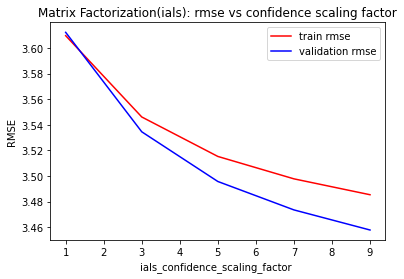

In [46]:

plt.plot(ials_scale, ials_train_scale, color= 'r' ,label='train rmse' )
plt.plot(ials_scale,  ials_val_scale, color= 'b',label='validation rmse' )
plt.xlabel('ials_confidence_scaling_factor ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs confidence scaling factor')
plt.legend()
plt.show()

In [47]:

reg = np.logspace(-10, -1, 10)
def test_reg_vals():
    reg_list = []
    train = []
    val = []
    for loc, R in enumerate(reg):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = 2, regularization = R,\
                                                                   ials_confidence_scaling_factor = 40 )
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        reg_list.append(np.log10(R))
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return reg_list,train,val

In [48]:
ials_reg, ials_train_reg, ials_val_reg = test_reg_vals()

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.057736s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-10    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 109us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 16.302ms     | 3.6397                    |

| 1       | 35.818ms     | 3.4837                    |

| 2       | 56.435ms     | 3.43838                   |

| 3       | 71.301ms     | 3.436                     |

| 4       | 103.196ms    | 3.43517                   |

| 5       | 137.939ms    | 3.43477                   |

| 6       | 155.618ms    | 3.43448                   |

| 7       | 174.516ms    | 3.43422                   |

| 8       | 196.295ms    | 3.43398                   |

| 9       | 214.04ms     | 3.43384                   |

| 10      | 232.654ms    | 3.43373                   |

| 11      | 251.277ms    | 3.43365                   |

| 12      | 268.807ms    | 3.43359                   |

| 13      | 287.668ms    | 3.43353                   |

| 14      | 308.552ms    | 3.43343                   |

| 15      | 323.432ms    | 3.43332                   |

| 16      | 341.032ms    | 3.43326                   |

| 17      | 358.138ms    | 3.43323                   |

| 18      | 377.531ms    | 3.43321                   |

| 19      | 390.27ms     | 3.43317                   |

| 20      | 406.056ms    | 3.43308                   |

| 21      | 421.194ms    | 3.43302                   |

| 22      | 439.111ms    | 3.43301                   |

| 23      | 456.708ms    | 3.43301                   |

| 24      | 470.337ms    | 3.43299                   |

| FINAL   | 470.406ms    | 3.43299                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 127894

recommendations finished on 2000/10559 queries. users per second: 134273

recommendations finished on 3000/10559 queries. users per second: 129249

recommendations finished on 4000/10559 queries. users per second: 127669

recommendations finished on 5000/10559 queries. users per second: 132303

recommendations finished on 6000/10559 queries. users per second: 114804

recommendations finished on 7000/10559 queries. users per second: 114767

recommendations finished on 8000/10559 queries. users per second: 116043

recommendations finished on 9000/10559 queries. users per second: 117746

recommendations finished on 10000/10559 queries. users per second: 119821


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3855478738516902 | 0.09781686031365723 |
|   2    | 0.37153139501846805 | 0.18700284474114084 |
|   3    |  0.3316601950942328 | 0.24922398043526733 |
|   4    |  0.3057817975187047 |  0.3030103087702659 |
|   5    |  0.2855573444454965 |  0.3528777041046293 |
|   6    |  0.2733213372478456 | 0.40317416929580263 |
|   7    |  0.2572077983575286 | 0.43975693884240685 |
|   8    |  0.2458092622407426 | 0.48109531996354954 |
|   9    | 0.23260830676305647 |  0.5106874569202562 |
|   10   | 0.22061748271616627 |  0.5359081305982388 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4329900110516447

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.044994s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 57us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 18.674ms     | 3.66017                   |

| 1       | 32.421ms     | 3.50516                   |

| 2       | 47.23ms      | 3.43825                   |

| 3       | 61.344ms     | 3.4339                    |

| 4       | 72.373ms     | 3.43268                   |

| 5       | 89.012ms     | 3.43216                   |

| 6       | 102.385ms    | 3.43187                   |

| 7       | 121.974ms    | 3.43173                   |

| 8       | 134.397ms    | 3.43171                   |

| 9       | 150.605ms    | 3.4317                    |

| 10      | 165.855ms    | 3.4317                    |

| 11      | 179.208ms    | 3.43171                   |

| 12      | 191.317ms    | 3.43173                   |

| 13      | 210.666ms    | 3.43176                   |

| 14      | 224.958ms    | 3.43178                   |

| 15      | 233.53ms     | 3.43178                   |

| 16      | 250.896ms    | 3.43177                   |

| 17      | 270.526ms    | 3.43178                   |

| 18      | 282.498ms    | 3.4318                    |

| 19      | 296.931ms    | 3.43182                   |

| 20      | 313.166ms    | 3.43184                   |

| 21      | 324.411ms    | 3.43186                   |

| 22      | 334.718ms    | 3.43188                   |

| 23      | 352.094ms    | 3.4319                    |

| 24      | 364.561ms    | 3.43192                   |

| FINAL   | 364.63ms     | 3.43192                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 115247

recommendations finished on 2000/10559 queries. users per second: 129794

recommendations finished on 3000/10559 queries. users per second: 122334

recommendations finished on 4000/10559 queries. users per second: 131281

recommendations finished on 5000/10559 queries. users per second: 131234

recommendations finished on 6000/10559 queries. users per second: 125992

recommendations finished on 7000/10559 queries. users per second: 121941

recommendations finished on 8000/10559 queries. users per second: 120797

recommendations finished on 9000/10559 queries. users per second: 119360

recommendations finished on 10000/10559 queries. users per second: 120846


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38886258168387194 | 0.09876330253112224 |
|   2    |  0.3719102187707164 |  0.1864459157846862 |
|   3    | 0.32367332765097745 |  0.2446650111925603 |
|   4    | 0.29794488114404766 |  0.2963876324649796 |
|   5    | 0.28428828487546093 | 0.35106342960899367 |
|   6    | 0.27229535625217005 | 0.40143342913239044 |
|   7    |  0.2559901505824418 |  0.4374824003759944 |
|   8    |  0.2409200681882754 | 0.47005029658272884 |
|   9    |  0.2301775210194571 |  0.5055678261682408 |
|   10   | 0.22254001325883147 |  0.5417563351068975 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4319164171166867

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.043772s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 17.441ms     | 3.6873                    |

| 1       | 34.388ms     | 3.61543                   |

| 2       | 46.604ms     | 3.51441                   |

| 3       | 62.182ms     | 3.44473                   |

| 4       | 79.066ms     | 3.43435                   |

| 5       | 95.346ms     | 3.43387                   |

| 6       | 110.648ms    | 3.43355                   |

| 7       | 124.705ms    | 3.43317                   |

| 8       | 138.252ms    | 3.43275                   |

| 9       | 150.891ms    | 3.43231                   |

| 10      | 164.989ms    | 3.43186                   |

| 11      | 178.337ms    | 3.43157                   |

| 12      | 192.311ms    | 3.43145                   |

| 13      | 204.154ms    | 3.43135                   |

| 14      | 217.769ms    | 3.43129                   |

| 15      | 234.956ms    | 3.4313                    |

| 16      | 249.042ms    | 3.43132                   |

| 17      | 260.673ms    | 3.43134                   |

| 18      | 276.242ms    | 3.43137                   |

| 19      | 287.954ms    | 3.43141                   |

| 20      | 301.169ms    | 3.43145                   |

| 21      | 316.839ms    | 3.43149                   |

| 22      | 328.602ms    | 3.43152                   |

| 23      | 344.786ms    | 3.43154                   |

| 24      | 361.938ms    | 3.43154                   |

| FINAL   | 362.011ms    | 3.43154                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 119603

recommendations finished on 2000/10559 queries. users per second: 133440

recommendations finished on 3000/10559 queries. users per second: 124409

recommendations finished on 4000/10559 queries. users per second: 129496

recommendations finished on 5000/10559 queries. users per second: 125386

recommendations finished on 6000/10559 queries. users per second: 122127

recommendations finished on 7000/10559 queries. users per second: 123437

recommendations finished on 8000/10559 queries. users per second: 124154

recommendations finished on 9000/10559 queries. users per second: 122668

recommendations finished on 10000/10559 queries. users per second: 118616


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38583199166587767 | 0.09714677300830413 |
|   2    | 0.37891845818732806 |  0.1918991326333952 |
|   3    |  0.3290715661205289 | 0.24798474170354942 |
|   4    |  0.3013306184297758 | 0.30169052137663893 |
|   5    | 0.28517852069324756 |  0.3518257241502925 |
|   6    | 0.27256368974334716 |  0.4018286309864813 |
|   7    | 0.25582779754576285 |  0.437293171216164  |
|   8    |  0.2399019793541055 |  0.4686503727769837 |
|   9    | 0.22778882680388488 |  0.5007650911972218 |
|   10   | 0.21842977554692672 |  0.5329936769669757 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4315371771194476

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.042323s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-07    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 18.825ms     | 3.68234                   |

| 1       | 37.641ms     | 3.44977                   |

| 2       | 54.999ms     | 3.43594                   |

| 3       | 66.564ms     | 3.43473                   |

| 4       | 85.218ms     | 3.43434                   |

| 5       | 102.942ms    | 3.43416                   |

| 6       | 115.824ms    | 3.43397                   |

| 7       | 131.091ms    | 3.43383                   |

| 8       | 147.063ms    | 3.43378                   |

| 9       | 161.583ms    | 3.43369                   |

| 10      | 178.347ms    | 3.43353                   |

| 11      | 226.635ms    | 3.43338                   |

| 12      | 248.615ms    | 3.43315                   |

| 13      | 275.326ms    | 3.43305                   |

| 14      | 289.246ms    | 3.43302                   |

| 15      | 305.596ms    | 3.43297                   |

| 16      | 318.436ms    | 3.43289                   |

| 17      | 333.473ms    | 3.43288                   |

| 18      | 348.462ms    | 3.4329                    |

| 19      | 360.549ms    | 3.43293                   |

| 20      | 379.165ms    | 3.43294                   |

| 21      | 392.241ms    | 3.43294                   |

| 22      | 408.217ms    | 3.43292                   |

| 23      | 431.527ms    | 3.4329                    |

| 24      | 450.309ms    | 3.43288                   |

| FINAL   | 450.422ms    | 3.43288                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 123594

recommendations finished on 2000/10559 queries. users per second: 132284

recommendations finished on 3000/10559 queries. users per second: 124152

recommendations finished on 4000/10559 queries. users per second: 129358

recommendations finished on 5000/10559 queries. users per second: 129809

recommendations finished on 6000/10559 queries. users per second: 113867

recommendations finished on 7000/10559 queries. users per second: 115909

recommendations finished on 8000/10559 queries. users per second: 113449

recommendations finished on 9000/10559 queries. users per second: 115890

recommendations finished on 10000/10559 queries. users per second: 116082


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38583199166587734 | 0.09817262404942022 |
|   2    |  0.3795813997537646 |  0.191504854695497  |
|   3    |  0.3308078416516715 | 0.24836952233331303 |
|   4    | 0.30313003125295945 | 0.30285654675842966 |
|   5    |  0.2814092243583673 | 0.34828453375771273 |
|   6    |  0.2670707453357329 |  0.3949701159793311 |
|   7    | 0.25088955934679974 |  0.4305275955917699 |
|   8    | 0.23579410929065253 | 0.46183259110946606 |
|   9    | 0.22498974019004342 | 0.49438694491684804 |
|   10   |  0.2149635382138459 |  0.5239102167855091 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.432876033089351

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.041881s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-06    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 154us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 14.486ms     | 3.75186                   |

| 1       | 43.903ms     | 3.49076                   |

| 2       | 59.941ms     | 3.4377                    |

| 3       | 76.008ms     | 3.43463                   |

| 4       | 88.662ms     | 3.43387                   |

| 5       | 102.758ms    | 3.43353                   |

| 6       | 117.209ms    | 3.43338                   |

| 7       | 133.25ms     | 3.43327                   |

| 8       | 151.754ms    | 3.43319                   |

| 9       | 163.375ms    | 3.43311                   |

| 10      | 176.58ms     | 3.43307                   |

| 11      | 189.028ms    | 3.43306                   |

| 12      | 201.781ms    | 3.43307                   |

| 13      | 217.228ms    | 3.43308                   |

| 14      | 231.592ms    | 3.4331                    |

| 15      | 243.742ms    | 3.43311                   |

| 16      | 257.995ms    | 3.43311                   |

| 17      | 272.311ms    | 3.43312                   |

| 18      | 284.838ms    | 3.43312                   |

| 19      | 300.498ms    | 3.43312                   |

| 20      | 313.177ms    | 3.43311                   |

| 21      | 335.1ms      | 3.4331                    |

| 22      | 346.585ms    | 3.4331                    |

| 23      | 361.63ms     | 3.43311                   |

| 24      | 374.713ms    | 3.43312                   |

| FINAL   | 374.795ms    | 3.43312                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 118413

recommendations finished on 2000/10559 queries. users per second: 130890

recommendations finished on 3000/10559 queries. users per second: 109441

recommendations finished on 4000/10559 queries. users per second: 107988

recommendations finished on 5000/10559 queries. users per second: 103926

recommendations finished on 6000/10559 queries. users per second: 108135

recommendations finished on 7000/10559 queries. users per second: 107739

recommendations finished on 8000/10559 queries. users per second: 109774

recommendations finished on 9000/10559 queries. users per second: 110633

recommendations finished on 10000/10559 queries. users per second: 112547


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3719102187707171 | 0.09451907705133294 |
|   2    | 0.37707169239511323 |  0.1893855307979014 |
|   3    |  0.3308394102976917 | 0.24796641794244734 |
|   4    |  0.2992944407614358 |  0.2969058949208014 |
|   5    |  0.2799886352874324 |  0.3463799695117811 |
|   6    |  0.2658553524639326 |  0.3926808017590181 |
|   7    |  0.2484813226360722 |  0.4258211078809033 |
|   8    | 0.23432616725068653 |  0.4584011477477307 |
|   9    | 0.22344287653502534 | 0.49080242967518833 |
|   10   |  0.212595889762288  |  0.5174929084519138 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4331183271234917

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.042119s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 14.682ms     | 3.77461                   |

| 1       | 31.64ms      | 3.4943                    |

| 2       | 44.405ms     | 3.43986                   |

| 3       | 59.023ms     | 3.43741                   |

| 4       | 73.76ms      | 3.43669                   |

| 5       | 89.31ms      | 3.43623                   |

| 6       | 102.063ms    | 3.43572                   |

| 7       | 121.68ms     | 3.43515                   |

| 8       | 136.707ms    | 3.43451                   |

| 9       | 148.965ms    | 3.43395                   |

| 10      | 164.053ms    | 3.43356                   |

| 11      | 176.843ms    | 3.43325                   |

| 12      | 194.103ms    | 3.43299                   |

| 13      | 207.981ms    | 3.43275                   |

| 14      | 218.648ms    | 3.43259                   |

| 15      | 233.323ms    | 3.43255                   |

| 16      | 257.493ms    | 3.43252                   |

| 17      | 268.85ms     | 3.43249                   |

| 18      | 283.799ms    | 3.43246                   |

| 19      | 299.324ms    | 3.43243                   |

| 20      | 318.383ms    | 3.43238                   |

| 21      | 331.426ms    | 3.43231                   |

| 22      | 342.547ms    | 3.4323                    |

| 23      | 368.547ms    | 3.43229                   |

| 24      | 385.616ms    | 3.43229                   |

| FINAL   | 385.685ms    | 3.43229                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 120265

recommendations finished on 2000/10559 queries. users per second: 134580

recommendations finished on 3000/10559 queries. users per second: 129110

recommendations finished on 4000/10559 queries. users per second: 130014

recommendations finished on 5000/10559 queries. users per second: 132345

recommendations finished on 6000/10559 queries. users per second: 126326

recommendations finished on 7000/10559 queries. users per second: 125563

recommendations finished on 8000/10559 queries. users per second: 124314

recommendations finished on 9000/10559 queries. users per second: 126711

recommendations finished on 10000/10559 queries. users per second: 126865


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39066199450705574 | 0.09883208089211575 |
|   2    |  0.3752249266028986 |  0.1874950485662277 |
|   3    |  0.3223474445181047 | 0.24342600504186765 |
|   4    | 0.29962591154465296 |  0.297516912603873  |
|   5    | 0.28570887394639616 | 0.35238046649521326 |
|   6    |  0.2720585914070142 |  0.400749718895636  |
|   7    | 0.25465073802984584 | 0.43513116665358625 |
|   8    | 0.23990197935410554 |   0.46844937548109  |
|   9    |  0.2284412454883144 |  0.502347715475706  |
|   10   | 0.21976512927360542 |  0.5360922364583103 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.432292832122163

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.046439s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 97us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 16.593ms     | 3.71331                   |

| 1       | 35.971ms     | 3.44342                   |

| 2       | 49.509ms     | 3.43767                   |

| 3       | 67.342ms     | 3.4367                    |

| 4       | 81.341ms     | 3.43588                   |

| 5       | 97.81ms      | 3.43519                   |

| 6       | 111.468ms    | 3.4349                    |

| 7       | 128.415ms    | 3.43477                   |

| 8       | 144.389ms    | 3.43468                   |

| 9       | 155.34ms     | 3.43462                   |

| 10      | 173.047ms    | 3.43459                   |

| 11      | 189.271ms    | 3.43457                   |

| 12      | 204.91ms     | 3.43456                   |

| 13      | 251.368ms    | 3.43454                   |

| 14      | 290.139ms    | 3.43452                   |

| 15      | 315.484ms    | 3.43449                   |

| 16      | 326.866ms    | 3.43447                   |

| 17      | 352.211ms    | 3.43446                   |

| 18      | 368.482ms    | 3.43445                   |

| 19      | 383.597ms    | 3.43444                   |

| 20      | 400.804ms    | 3.43443                   |

| 21      | 428.201ms    | 3.43441                   |

| 22      | 443.212ms    | 3.43437                   |

| 23      | 458.339ms    | 3.43433                   |

| 24      | 472.45ms     | 3.43431                   |

| FINAL   | 472.508ms    | 3.43431                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 120178

recommendations finished on 2000/10559 queries. users per second: 130081

recommendations finished on 3000/10559 queries. users per second: 122349

recommendations finished on 4000/10559 queries. users per second: 124081

recommendations finished on 5000/10559 queries. users per second: 125348

recommendations finished on 6000/10559 queries. users per second: 117204

recommendations finished on 7000/10559 queries. users per second: 115397

recommendations finished on 8000/10559 queries. users per second: 118747

recommendations finished on 9000/10559 queries. users per second: 118727

recommendations finished on 10000/10559 queries. users per second: 114858


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39056728856899287 | 0.09930680321537345 |
|   2    |  0.3753196325409603 | 0.18852058768735508 |
|   3    |  0.3306184297755466 | 0.24729910625254853 |
|   4    | 0.30464532626195706 | 0.30176049341205113 |
|   5    |  0.2837579316223131 |  0.3505888962058466 |
|   6    | 0.26939104081825915 |  0.397993433184444  |
|   7    | 0.25136308903711113 | 0.43114940474273844 |
|   8    | 0.23735675726868066 | 0.46447579464155325 |
|   9    | 0.22589470804263823 |  0.4954990623766433 |
|   10   |  0.2176721280424281 |  0.5307726104133483 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4343115786222587

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.049971s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 16.623ms     | 3.82197                   |

| 1       | 33.244ms     | 3.51644                   |

| 2       | 46.122ms     | 3.47581                   |

| 3       | 66.078ms     | 3.46421                   |

| 4       | 83.147ms     | 3.45845                   |

| 5       | 101.416ms    | 3.45454                   |

| 6       | 117.863ms    | 3.45166                   |

| 7       | 130.489ms    | 3.44941                   |

| 8       | 143.401ms    | 3.44775                   |

| 9       | 159.098ms    | 3.44651                   |

| 10      | 173.573ms    | 3.44556                   |

| 11      | 188.802ms    | 3.44479                   |

| 12      | 199.964ms    | 3.44415                   |

| 13      | 213.947ms    | 3.44361                   |

| 14      | 227.585ms    | 3.44313                   |

| 15      | 247.171ms    | 3.44271                   |

| 16      | 262.073ms    | 3.44233                   |

| 17      | 272.636ms    | 3.442                     |

| 18      | 290.949ms    | 3.4417                    |

| 19      | 304.029ms    | 3.44143                   |

| 20      | 326.703ms    | 3.44118                   |

| 21      | 339.395ms    | 3.44094                   |

| 22      | 352.897ms    | 3.44073                   |

| 23      | 371.375ms    | 3.44054                   |

| 24      | 384.326ms    | 3.44036                   |

| FINAL   | 384.418ms    | 3.44036                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 121507

recommendations finished on 2000/10559 queries. users per second: 138870

recommendations finished on 3000/10559 queries. users per second: 138185

recommendations finished on 4000/10559 queries. users per second: 138117

recommendations finished on 5000/10559 queries. users per second: 142041

recommendations finished on 6000/10559 queries. users per second: 136024

recommendations finished on 7000/10559 queries. users per second: 134797

recommendations finished on 8000/10559 queries. users per second: 129118

recommendations finished on 9000/10559 queries. users per second: 127515

recommendations finished on 10000/10559 queries. users per second: 121671


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4112131830665781 | 0.10409724332284151 |
|   2    |  0.3844114025949431 |  0.1897634366785701 |
|   3    | 0.33854215992676023 |  0.2525019668571989 |
|   4    |  0.3018515010891181 | 0.29855395314263516 |
|   5    |  0.2849133440666731 | 0.35210449989406084 |
|   6    |  0.2687912365438653 |  0.3966490711067652 |
|   7    |  0.250970735865139  |  0.4294677950275736 |
|   8    |  0.2363623449190264 | 0.46130055806209874 |
|   9    | 0.22410581810146163 | 0.49219105295723403 |
|   10   |  0.213249360734918  |  0.5178534823522623 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.440357103186386

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.045732s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.01     |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 81us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 14.52ms      | 3.89992                   |

| 1       | 31.592ms     | 3.61975                   |

| 2       | 46.293ms     | 3.45563                   |

| 3       | 61.73ms      | 3.45494                   |

| 4       | 74.657ms     | 3.45602                   |

| 5       | 91.88ms      | 3.45741                   |

| 6       | 104.773ms    | 3.45877                   |

| 7       | 121.693ms    | 3.45995                   |

| 8       | 137.642ms    | 3.46093                   |

| 9       | 149.845ms    | 3.46171                   |

| 10      | 163.703ms    | 3.46233                   |

| 11      | 179.991ms    | 3.46282                   |

| 12      | 204.734ms    | 3.46322                   |

| 13      | 218.533ms    | 3.46354                   |

| 14      | 229.787ms    | 3.46381                   |

| 15      | 242.811ms    | 3.46403                   |

| 16      | 255.31ms     | 3.46421                   |

| 17      | 272.274ms    | 3.46435                   |

| 18      | 287.925ms    | 3.46447                   |

| 19      | 301.795ms    | 3.46456                   |

| 20      | 311.895ms    | 3.46463                   |

| 21      | 324.677ms    | 3.46469                   |

| 22      | 344.481ms    | 3.46473                   |

| 23      | 355.3ms      | 3.46476                   |

| 24      | 372.109ms    | 3.46479                   |

| FINAL   | 372.176ms    | 3.46479                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 125455

recommendations finished on 2000/10559 queries. users per second: 140252

recommendations finished on 3000/10559 queries. users per second: 136036

recommendations finished on 4000/10559 queries. users per second: 135099

recommendations finished on 5000/10559 queries. users per second: 139579

recommendations finished on 6000/10559 queries. users per second: 131886

recommendations finished on 7000/10559 queries. users per second: 133214

recommendations finished on 8000/10559 queries. users per second: 128808

recommendations finished on 9000/10559 queries. users per second: 124567

recommendations finished on 10000/10559 queries. users per second: 121545


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.41452789089875935 |  0.1032840487448049 |
|   2    |  0.4028317075480634 | 0.19928413063340866 |
|   3    | 0.34757079268870167 |  0.255166122807065  |
|   4    | 0.30900179941282296 | 0.30280930940647977 |
|   5    |  0.2874135808315179 |  0.3514973648775545 |
|   6    |  0.2725163367743157 | 0.39769683290593144 |
|   7    |  0.2530001488236167 | 0.42847306617897424 |
|   8    | 0.24010322947248788 |  0.4660370887825923 |
|   9    |  0.2276099378097674 |  0.495461160042425  |
|   10   | 0.21789942229377768 |  0.5253568970762046 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4647903492758387

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.047065s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.1      |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 92us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 17.055ms     | 3.90018                   |

| 1       | 30.547ms     | 3.90016                   |

| 2       | 46.836ms     | 3.89827                   |

| 3       | 65.412ms     | 3.82158                   |

| 4       | 80.79ms      | 3.69381                   |

| 5       | 96.754ms     | 3.67705                   |

| 6       | 119.634ms    | 3.67522                   |

| 7       | 134.079ms    | 3.67499                   |

| 8       | 147.407ms    | 3.67496                   |

| 9       | 167.338ms    | 3.67496                   |

| 10      | 181.143ms    | 3.67495                   |

| 11      | 196.34ms     | 3.67495                   |

| 12      | 208.003ms    | 3.67495                   |

| 13      | 223.882ms    | 3.67495                   |

| 14      | 236.937ms    | 3.67495                   |

| 15      | 254.453ms    | 3.67495                   |

| 16      | 268.641ms    | 3.67495                   |

| 17      | 283.731ms    | 3.67495                   |

| 18      | 303.03ms     | 3.67495                   |

| 19      | 319.787ms    | 3.67495                   |

| 20      | 329.525ms    | 3.67495                   |

| 21      | 340.239ms    | 3.67495                   |

| 22      | 356.776ms    | 3.67495                   |

| 23      | 373.894ms    | 3.67495                   |

| 24      | 388.699ms    | 3.67495                   |

| FINAL   | 388.775ms    | 3.67495                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 124735

recommendations finished on 2000/10559 queries. users per second: 142582

recommendations finished on 3000/10559 queries. users per second: 150905

recommendations finished on 4000/10559 queries. users per second: 149371

recommendations finished on 5000/10559 queries. users per second: 157480

recommendations finished on 6000/10559 queries. users per second: 155312

recommendations finished on 7000/10559 queries. users per second: 152688

recommendations finished on 8000/10559 queries. users per second: 156223

recommendations finished on 9000/10559 queries. users per second: 155210

recommendations finished on 10000/10559 queries. users per second: 151867


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.42343024907661725 | 0.10497490742259424 |
|   2    | 0.40922435836726945 | 0.20113829756671062 |
|   3    |  0.3503172648925087 |  0.255604353011371  |
|   4    |  0.3065394450232034 | 0.29812694722945005 |
|   5    | 0.28659910976418246 | 0.34745387677070794 |
|   6    | 0.27119045364144345 |  0.392455352921341  |
|   7    | 0.25036191197759555 |  0.4204870667116499 |
|   8    | 0.23379344634908608 | 0.44680306014266236 |
|   9    | 0.22227483663225667 |  0.4776758972688079 |
|   10   | 0.20684723932190544 |  0.4935493284634168 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.674954111722182

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

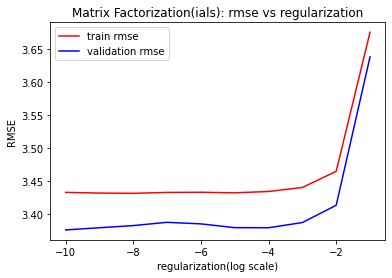

In [49]:
plt.plot(ials_reg, ials_train_reg, color= 'r' ,label='train rmse' )
plt.plot(ials_reg,  ials_val_reg, color= 'b',label='validation rmse' )
plt.xlabel('regularization(log scale)')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs regularization')
plt.legend()
plt.show()

In [50]:

maxIter = np.arange(10,100, 10)
def test_iter_vals():
    maxIter_list = []
    train = []
    val = []
    for loc, iter_num in enumerate(maxIter):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 2, regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 40 ,\
                                                            max_iterations = iter_num
                                                           )
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        maxIter_list.append(iter_num)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return maxIter_list,train,val

In [51]:
ials_iter, ials_train_iter, ials_val_iter = test_iter_vals() 

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.047697s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 10       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 78us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 16.146ms     | 3.80094                   |

| 1       | 33.789ms     | 3.53695                   |

| 2       | 47.816ms     | 3.45134                   |

| 3       | 67.78ms      | 3.43776                   |

| 4       | 89.022ms     | 3.43632                   |

| 5       | 122.907ms    | 3.43557                   |

| 6       | 143.337ms    | 3.43507                   |

| 7       | 163.408ms    | 3.43471                   |

| 8       | 186.775ms    | 3.43443                   |

| 9       | 201.562ms    | 3.43416                   |

| FINAL   | 201.626ms    | 3.43416                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 103520

recommendations finished on 2000/10559 queries. users per second: 112619

recommendations finished on 3000/10559 queries. users per second: 110298

recommendations finished on 4000/10559 queries. users per second: 115141

recommendations finished on 5000/10559 queries. users per second: 120415

recommendations finished on 6000/10559 queries. users per second: 120853

recommendations finished on 7000/10559 queries. users per second: 120965

recommendations finished on 8000/10559 queries. users per second: 119392

recommendations finished on 9000/10559 queries. users per second: 118178

recommendations finished on 10000/10559 queries. users per second: 117243


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37835022255895445 | 0.09616608919502133 |
|   2    |  0.3839852258736623 |  0.1951659806591602 |
|   3    | 0.33525902074060093 |  0.2509747099006304 |
|   4    |  0.3042191495406763 | 0.30163137886289776 |
|   5    |  0.2842504025002369 |  0.3512270234995031 |
|   6    | 0.26883858951289563 | 0.39717917625822785 |
|   7    |  0.252445442614966  |  0.4308737456140249 |
|   8    |  0.2370726394544938 |  0.4622265261937245 |
|   9    | 0.22608411991876343 | 0.49536124103924534 |
|   10   | 0.21715124538308528 |  0.5278741734919271 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4341604121697866

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.049435s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 20       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 117us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 22.269ms     | 3.78164                   |

| 1       | 35.621ms     | 3.52421                   |

| 2       | 52.433ms     | 3.44284                   |

| 3       | 68.601ms     | 3.43647                   |

| 4       | 83.218ms     | 3.43485                   |

| 5       | 95.844ms     | 3.43396                   |

| 6       | 110.475ms    | 3.43351                   |

| 7       | 129.692ms    | 3.43325                   |

| 8       | 145.413ms    | 3.4331                    |

| 9       | 159.471ms    | 3.43302                   |

| 10      | 176.036ms    | 3.43298                   |

| 11      | 187.836ms    | 3.43295                   |

| 12      | 203.777ms    | 3.43293                   |

| 13      | 223.504ms    | 3.43291                   |

| 14      | 240.61ms     | 3.4329                    |

| 15      | 257.7ms      | 3.4329                    |

| 16      | 272.132ms    | 3.43289                   |

| 17      | 284.921ms    | 3.43289                   |

| 18      | 309.022ms    | 3.43289                   |

| 19      | 324.784ms    | 3.43289                   |

| FINAL   | 325.053ms    | 3.43289                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 72369.4

recommendations finished on 2000/10559 queries. users per second: 98633.9

recommendations finished on 3000/10559 queries. users per second: 108292

recommendations finished on 4000/10559 queries. users per second: 112233

recommendations finished on 5000/10559 queries. users per second: 118251

recommendations finished on 6000/10559 queries. users per second: 112653

recommendations finished on 7000/10559 queries. users per second: 113175

recommendations finished on 8000/10559 queries. users per second: 114926

recommendations finished on 9000/10559 queries. users per second: 117776

recommendations finished on 10000/10559 queries. users per second: 119491


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.386684345108438  | 0.09806346767203919 |
|   2    |  0.3714366890804051 | 0.18690655152801955 |
|   3    |  0.328250781323989  | 0.24875868530825382 |
|   4    |  0.2982526754427502 |  0.2961187409421818 |
|   5    |  0.2841367553745615 | 0.35052984572944956 |
|   6    | 0.27136408119455807 | 0.39962892113423865 |
|   7    | 0.25562485624991554 | 0.43666226432460764 |
|   8    |  0.2421867601098589 |  0.4728919614865049 |
|   9    | 0.23111405751807293 |  0.5067959821425982 |
|   10   |  0.2218486599109759 |  0.5388669480701008 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4328892264159516

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.042922s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 30       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 85us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 24.17ms      | 3.76555                   |

| 1       | 41.17ms      | 3.47055                   |

| 2       | 74.656ms     | 3.44035                   |

| 3       | 95.781ms     | 3.43753                   |

| 4       | 110.376ms    | 3.4367                    |

| 5       | 127.248ms    | 3.43631                   |

| 6       | 147.156ms    | 3.43611                   |

| 7       | 164.428ms    | 3.43598                   |

| 8       | 185.381ms    | 3.4359                    |

| 9       | 201.826ms    | 3.43585                   |

| 10      | 220.12ms     | 3.43581                   |

| 11      | 236.442ms    | 3.43577                   |

| 12      | 250.483ms    | 3.43574                   |

| 13      | 261.55ms     | 3.43571                   |

| 14      | 272.73ms     | 3.43568                   |

| 15      | 288.522ms    | 3.43564                   |

| 16      | 304.373ms    | 3.43556                   |

| 17      | 314.057ms    | 3.43545                   |

| 18      | 334.392ms    | 3.43532                   |

| 19      | 347.483ms    | 3.43518                   |

| 20      | 360.608ms    | 3.43501                   |

| 21      | 376.849ms    | 3.43485                   |

| 22      | 390.943ms    | 3.43477                   |

| 23      | 406.569ms    | 3.43471                   |

| 24      | 426.929ms    | 3.43465                   |

| 25      | 440.776ms    | 3.43459                   |

| 26      | 457.704ms    | 3.43453                   |

| 27      | 469.487ms    | 3.43449                   |

| 28      | 487.702ms    | 3.43443                   |

| 29      | 504.785ms    | 3.43438                   |

| FINAL   | 504.845ms    | 3.43438                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 129349

recommendations finished on 2000/10559 queries. users per second: 125133

recommendations finished on 3000/10559 queries. users per second: 114486

recommendations finished on 4000/10559 queries. users per second: 114136

recommendations finished on 5000/10559 queries. users per second: 117459

recommendations finished on 6000/10559 queries. users per second: 115340

recommendations finished on 7000/10559 queries. users per second: 113679

recommendations finished on 8000/10559 queries. users per second: 114219

recommendations finished on 9000/10559 queries. users per second: 116680

recommendations finished on 10000/10559 queries. users per second: 115781


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37910787006345253 | 0.09641065050508117 |
|   2    |  0.3674116867127568 | 0.18411665022909587 |
|   3    |  0.3254727404741616 | 0.24218332276446744 |
|   4    | 0.29242826025191765 |  0.2891746176114387 |
|   5    |  0.276238280140165  |  0.3411187908352011 |
|   6    |  0.2633298607822702 |  0.3882808349928237 |
|   7    | 0.24555896797586346 |  0.4198954201513599 |
|   8    |  0.2323018278246046 |  0.453652981212644  |
|   9    | 0.21941261272637333 | 0.48038395338470896 |
|   10   | 0.21194241878965792 |  0.5152727428140631 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.434376076391192

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.042561s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 40       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 69us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 14.154ms     | 3.74946                   |

| 1       | 32.73ms      | 3.46323                   |

| 2       | 47.368ms     | 3.43692                   |

| 3       | 63.454ms     | 3.43521                   |

| 4       | 75.809ms     | 3.43475                   |

| 5       | 90.227ms     | 3.43453                   |

| 6       | 109.84ms     | 3.43443                   |

| 7       | 123.133ms    | 3.4344                    |

| 8       | 140.099ms    | 3.43438                   |

| 9       | 158.638ms    | 3.43435                   |

| 10      | 170.87ms     | 3.43431                   |

| 11      | 184.385ms    | 3.43429                   |

| 12      | 197.119ms    | 3.43428                   |

| 13      | 214.532ms    | 3.43427                   |

| 14      | 227.849ms    | 3.43425                   |

| 15      | 240.395ms    | 3.43424                   |

| 16      | 256.623ms    | 3.43422                   |

| 17      | 268.611ms    | 3.4342                    |

| 18      | 283.121ms    | 3.43418                   |

| 19      | 295.057ms    | 3.43416                   |

| 20      | 308.571ms    | 3.43413                   |

| 21      | 320.741ms    | 3.4341                    |

| 22      | 336.037ms    | 3.43406                   |

| 23      | 350.062ms    | 3.43404                   |

| 24      | 363.494ms    | 3.43402                   |

| 25      | 378.254ms    | 3.43399                   |

| 26      | 391.175ms    | 3.43384                   |

| 27      | 403.238ms    | 3.43366                   |

| 28      | 424.663ms    | 3.43362                   |

| 29      | 434.912ms    | 3.4336                    |

| 30      | 449.808ms    | 3.43359                   |

| 31      | 464.166ms    | 3.43356                   |

| 32      | 475.597ms    | 3.43347                   |

| 33      | 490.594ms    | 3.43345                   |

| 34      | 503.202ms    | 3.43344                   |

| 35      | 518.477ms    | 3.43343                   |

| 36      | 531.725ms    | 3.43341                   |

| 37      | 592.297ms    | 3.43339                   |

| 38      | 627.281ms    | 3.43336                   |

| 39      | 639.112ms    | 3.43334                   |

| FINAL   | 639.207ms    | 3.43334                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 127747

recommendations finished on 2000/10559 queries. users per second: 135153

recommendations finished on 3000/10559 queries. users per second: 140193

recommendations finished on 4000/10559 queries. users per second: 136435

recommendations finished on 5000/10559 queries. users per second: 140568

recommendations finished on 6000/10559 queries. users per second: 135041

recommendations finished on 7000/10559 queries. users per second: 137573

recommendations finished on 8000/10559 queries. users per second: 139436

recommendations finished on 9000/10559 queries. users per second: 141203

recommendations finished on 10000/10559 queries. users per second: 136887


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38564257978975325 | 0.09783333648199445 |
|   2    |  0.3725731603371526 | 0.18734986752399985 |
|   3    | 0.33023960602329766 | 0.24760941330905137 |
|   4    |  0.3020882659342736 |  0.2998057615049644 |
|   5    | 0.28517852069324806 |  0.3527423771489985 |
|   6    |  0.2723269248981906 |  0.4018302552686892 |
|   7    | 0.25677485692638674 | 0.43920964381570216 |
|   8    | 0.24377308457240285 |  0.4758895004778005 |
|   9    | 0.23219791436478632 |  0.5096141463023143 |
|   10   | 0.22214224831896956 |  0.5400124245828545 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4333426162327165

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.048116s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 61us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 13.045ms     | 3.75488                   |

| 1       | 34.91ms      | 3.45812                   |

| 2       | 50.558ms     | 3.43888                   |

| 3       | 67.249ms     | 3.43634                   |

| 4       | 81.18ms      | 3.43498                   |

| 5       | 97.064ms     | 3.43391                   |

| 6       | 113.085ms    | 3.43333                   |

| 7       | 128.202ms    | 3.43314                   |

| 8       | 145.08ms     | 3.43308                   |

| 9       | 159.682ms    | 3.43305                   |

| 10      | 174.857ms    | 3.43304                   |

| 11      | 189.013ms    | 3.43303                   |

| 12      | 203.907ms    | 3.43301                   |

| 13      | 214.495ms    | 3.43299                   |

| 14      | 230.107ms    | 3.43298                   |

| 15      | 243.924ms    | 3.43297                   |

| 16      | 257.229ms    | 3.43297                   |

| 17      | 271.49ms     | 3.43297                   |

| 18      | 283.366ms    | 3.43297                   |

| 19      | 298.521ms    | 3.43297                   |

| 20      | 312.038ms    | 3.43297                   |

| 21      | 326.414ms    | 3.43297                   |

| 22      | 339.071ms    | 3.43296                   |

| 23      | 352.247ms    | 3.43296                   |

| 24      | 367.533ms    | 3.43295                   |

| 25      | 382.899ms    | 3.43295                   |

| 26      | 392.306ms    | 3.43295                   |

| 27      | 405.366ms    | 3.43295                   |

| 28      | 431.068ms    | 3.43295                   |

| 29      | 441.045ms    | 3.43295                   |

| 30      | 453.699ms    | 3.43295                   |

| 31      | 468.123ms    | 3.43295                   |

| 32      | 482.641ms    | 3.43295                   |

| 33      | 495.018ms    | 3.43295                   |

| 34      | 507.946ms    | 3.43295                   |

| 35      | 521.69ms     | 3.43295                   |

| 36      | 535.602ms    | 3.43295                   |

| 37      | 547.12ms     | 3.43295                   |

| 38      | 562.41ms     | 3.43295                   |

| 39      | 576.342ms    | 3.43294                   |

| 40      | 586.007ms    | 3.43293                   |

| 41      | 606.284ms    | 3.43292                   |

| 42      | 617.074ms    | 3.4329                    |

| 43      | 627.273ms    | 3.43289                   |

| 44      | 643.758ms    | 3.43287                   |

| 45      | 657.538ms    | 3.43286                   |

| 46      | 668.975ms    | 3.43285                   |

| 47      | 681.863ms    | 3.43285                   |

| 48      | 698.421ms    | 3.43284                   |

| 49      | 710.444ms    | 3.43284                   |

| FINAL   | 710.522ms    | 3.43284                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 54579.2

recommendations finished on 2000/10559 queries. users per second: 72356.3

recommendations finished on 3000/10559 queries. users per second: 84645.3

recommendations finished on 4000/10559 queries. users per second: 91153.5

recommendations finished on 5000/10559 queries. users per second: 98784.9

recommendations finished on 6000/10559 queries. users per second: 100360

recommendations finished on 7000/10559 queries. users per second: 103242

recommendations finished on 8000/10559 queries. users per second: 103784

recommendations finished on 9000/10559 queries. users per second: 105216

recommendations finished on 10000/10559 queries. users per second: 106554


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38668434510843863 | 0.09764695392092955 |
|   2    | 0.38048110616535663 | 0.19341097485458497 |
|   3    | 0.32679862360703354 | 0.24466050782481244 |
|   4    |  0.2987735581020935 |  0.2964103160561836 |
|   5    | 0.28466710862771116 | 0.35062621814606165 |
|   6    | 0.27038545316791335 |  0.397900898620675  |
|   7    |  0.2542448554381497 |  0.4343510536606716 |
|   8    |  0.2399019793541056 | 0.46859073690222147 |
|   9    | 0.22818869632014807 |  0.5014390474101689 |
|   10   | 0.21760583388578475 |  0.5292706864866605 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.432841028186616

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.046289s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 60       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 64us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 19.094ms     | 3.76982                   |

| 1       | 33.993ms     | 3.45704                   |

| 2       | 48.412ms     | 3.43963                   |

| 3       | 62.371ms     | 3.43558                   |

| 4       | 80.186ms     | 3.43497                   |

| 5       | 92.266ms     | 3.43472                   |

| 6       | 109.994ms    | 3.43458                   |

| 7       | 127.128ms    | 3.43449                   |

| 8       | 141.81ms     | 3.43444                   |

| 9       | 165.438ms    | 3.43439                   |

| 10      | 181.825ms    | 3.43436                   |

| 11      | 194.373ms    | 3.43435                   |

| 12      | 209.477ms    | 3.43434                   |

| 13      | 220.185ms    | 3.43432                   |

| 14      | 232.406ms    | 3.43424                   |

| 15      | 249.393ms    | 3.43418                   |

| 16      | 264.417ms    | 3.43414                   |

| 17      | 279.622ms    | 3.43411                   |

| 18      | 294.917ms    | 3.43409                   |

| 19      | 310.927ms    | 3.43406                   |

| 20      | 330.098ms    | 3.43403                   |

| 21      | 346.894ms    | 3.434                     |

| 22      | 364.438ms    | 3.43396                   |

| 23      | 380.82ms     | 3.43393                   |

| 24      | 399.662ms    | 3.43391                   |

| 25      | 419.795ms    | 3.43387                   |

| 26      | 438.029ms    | 3.4337                    |

| 27      | 453.125ms    | 3.43352                   |

| 28      | 468.497ms    | 3.43349                   |

| 29      | 496.164ms    | 3.43348                   |

| 30      | 518.459ms    | 3.43348                   |

| 31      | 534.917ms    | 3.43344                   |

| 32      | 571.121ms    | 3.43336                   |

| 33      | 582.623ms    | 3.43335                   |

| 34      | 603.212ms    | 3.43335                   |

| 35      | 617.298ms    | 3.43335                   |

| 36      | 636.171ms    | 3.43334                   |

| 37      | 652.104ms    | 3.43332                   |

| 38      | 668.591ms    | 3.43329                   |

| 39      | 687.697ms    | 3.43326                   |

| 40      | 702.47ms     | 3.43324                   |

| 41      | 719.529ms    | 3.43323                   |

| 42      | 736.863ms    | 3.43322                   |

| 43      | 750.379ms    | 3.43322                   |

| 44      | 768.186ms    | 3.43321                   |

| 45      | 782.011ms    | 3.4332                    |

| 46      | 797.581ms    | 3.43318                   |

| 47      | 814.656ms    | 3.43317                   |

| 48      | 826.144ms    | 3.43316                   |

| 49      | 840.217ms    | 3.43315                   |

| 50      | 856.888ms    | 3.43315                   |

| 51      | 868.465ms    | 3.43314                   |

| 52      | 886.643ms    | 3.43311                   |

| 53      | 894.824ms    | 3.43307                   |

| 54      | 917.803ms    | 3.43306                   |

| 55      | 930.005ms    | 3.43306                   |

| 56      | 943.198ms    | 3.43305                   |

| 57      | 956.989ms    | 3.43305                   |

| 58      | 970.49ms     | 3.43305                   |

| 59      | 988.976ms    | 3.43305                   |

| FINAL   | 989.042ms    | 3.43305                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 116782

recommendations finished on 2000/10559 queries. users per second: 113052

recommendations finished on 3000/10559 queries. users per second: 110898

recommendations finished on 4000/10559 queries. users per second: 118888

recommendations finished on 5000/10559 queries. users per second: 122814

recommendations finished on 6000/10559 queries. users per second: 124719

recommendations finished on 7000/10559 queries. users per second: 126656

recommendations finished on 8000/10559 queries. users per second: 125731

recommendations finished on 9000/10559 queries. users per second: 128660

recommendations finished on 10000/10559 queries. users per second: 126298


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.378255516620892  | 0.09624545968825682 |
|   2    |  0.3670328629605075 |  0.1844038750122343 |
|   3    |  0.327145878713262  | 0.24596938220126735 |
|   4    |  0.2979212046595326 |  0.2958532119657129 |
|   5    |  0.2832844019320013 | 0.35019747888835984 |
|   6    |  0.270827414212204  | 0.39983745671384047 |
|   7    |  0.2542177965987036 |  0.4354197980758601 |
|   8    | 0.24192631878018753 | 0.47404157798427665 |
|   9    | 0.23102987446201773 |  0.5081262816090154 |
|   10   | 0.22063642390377858 |  0.5366444404071554 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4330544819356246

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.045859s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 70       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 18.331ms     | 3.77511                   |

| 1       | 37.199ms     | 3.49674                   |

| 2       | 54.257ms     | 3.4398                    |

| 3       | 67.234ms     | 3.43731                   |

| 4       | 85.825ms     | 3.43662                   |

| 5       | 97.516ms     | 3.43613                   |

| 6       | 124.541ms    | 3.43567                   |

| 7       | 139.217ms    | 3.43513                   |

| 8       | 154.869ms    | 3.4345                    |

| 9       | 164.629ms    | 3.43393                   |

| 10      | 176.948ms    | 3.43354                   |

| 11      | 191.026ms    | 3.43339                   |

| 12      | 203.682ms    | 3.43333                   |

| 13      | 214.903ms    | 3.43329                   |

| 14      | 228.488ms    | 3.43327                   |

| 15      | 246.109ms    | 3.43325                   |

| 16      | 259.459ms    | 3.43324                   |

| 17      | 274.924ms    | 3.43321                   |

| 18      | 285.593ms    | 3.43318                   |

| 19      | 310.785ms    | 3.43315                   |

| 20      | 320.733ms    | 3.43312                   |

| 21      | 333.907ms    | 3.43311                   |

| 22      | 344.521ms    | 3.4331                    |

| 23      | 358.183ms    | 3.4331                    |

| 24      | 373.882ms    | 3.43309                   |

| 25      | 386.376ms    | 3.43305                   |

| 26      | 402.772ms    | 3.43301                   |

| 27      | 413.734ms    | 3.43299                   |

| 28      | 428.768ms    | 3.43297                   |

| 29      | 441.854ms    | 3.43296                   |

| 30      | 456.441ms    | 3.43296                   |

| 31      | 488.337ms    | 3.43296                   |

| 32      | 501.35ms     | 3.43296                   |

| 33      | 513.823ms    | 3.43296                   |

| 34      | 528.707ms    | 3.43296                   |

| 35      | 547.955ms    | 3.43296                   |

| 36      | 563.226ms    | 3.43296                   |

| 37      | 576.948ms    | 3.43296                   |

| 38      | 591.824ms    | 3.43296                   |

| 39      | 607.404ms    | 3.43296                   |

| 40      | 621.196ms    | 3.43295                   |

| 41      | 637.135ms    | 3.43295                   |

| 42      | 648.815ms    | 3.43295                   |

| 43      | 671.215ms    | 3.43295                   |

| 44      | 684.574ms    | 3.43295                   |

| 45      | 699.507ms    | 3.43295                   |

| 46      | 717.421ms    | 3.43295                   |

| 47      | 732.208ms    | 3.43295                   |

| 48      | 749.564ms    | 3.43295                   |

| 49      | 758.968ms    | 3.43295                   |

| 50      | 776.696ms    | 3.43295                   |

| 51      | 795.961ms    | 3.43295                   |

| 52      | 811.722ms    | 3.43295                   |

| 53      | 824.762ms    | 3.43295                   |

| 54      | 839.09ms     | 3.43295                   |

| 55      | 857.504ms    | 3.43295                   |

| 56      | 869.318ms    | 3.43295                   |

| 57      | 882.726ms    | 3.43295                   |

| 58      | 896.988ms    | 3.43295                   |

| 59      | 914.401ms    | 3.43295                   |

| 60      | 925.791ms    | 3.43295                   |

| 61      | 939.246ms    | 3.43295                   |

| 62      | 956.315ms    | 3.43295                   |

| 63      | 966.668ms    | 3.43295                   |

| 64      | 981.913ms    | 3.43295                   |

| 65      | 996.86ms     | 3.43295                   |

| 66      | 1.01s        | 3.43295                   |

| 67      | 1.02s        | 3.43295                   |

| 68      | 1.03s        | 3.43295                   |

| 69      | 1.05s        | 3.43295                   |

| FINAL   | 1.05s        | 3.43295                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 111957

recommendations finished on 2000/10559 queries. users per second: 131277

recommendations finished on 3000/10559 queries. users per second: 134777

recommendations finished on 4000/10559 queries. users per second: 126666

recommendations finished on 5000/10559 queries. users per second: 125053

recommendations finished on 6000/10559 queries. users per second: 119923

recommendations finished on 7000/10559 queries. users per second: 121750

recommendations finished on 8000/10559 queries. users per second: 124195

recommendations finished on 9000/10559 queries. users per second: 125518

recommendations finished on 10000/10559 queries. users per second: 123574


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3851690500994416 | 0.09723149035554651 |
|   2    | 0.37181551283265424 | 0.18643725385491453 |
|   3    | 0.32528332859803594 |  0.2444447217659627 |
|   4    |  0.2983710578653276 |  0.2964491304302729 |
|   5    |  0.2843451084382991 |  0.351209616626277  |
|   6    |  0.271506140101651  | 0.39997460026566356 |
|   7    |  0.256166033038844  |  0.4376173790804963 |
|   8    | 0.24153565678568045 |  0.4711963353217487 |
|   9    |  0.2298092201492146 |  0.5039102744784334 |
|   10   | 0.22208542475613233 |  0.5401720795271101 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.432953140221937

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.048473s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 80       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 60us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 18.376ms     | 3.76483                   |

| 1       | 31.945ms     | 3.45962                   |

| 2       | 46.004ms     | 3.43867                   |

| 3       | 65.207ms     | 3.43729                   |

| 4       | 78.603ms     | 3.43672                   |

| 5       | 92.673ms     | 3.43618                   |

| 6       | 105.327ms    | 3.43576                   |

| 7       | 120.383ms    | 3.43552                   |

| 8       | 134.72ms     | 3.43532                   |

| 9       | 154.754ms    | 3.43508                   |

| 10      | 166.788ms    | 3.43481                   |

| 11      | 178.854ms    | 3.43466                   |

| 12      | 194.154ms    | 3.43456                   |

| 13      | 210.178ms    | 3.43448                   |

| 14      | 223.442ms    | 3.43442                   |

| 15      | 241.29ms     | 3.43437                   |

| 16      | 256.383ms    | 3.43433                   |

| 17      | 270.992ms    | 3.4343                    |

| 18      | 283.029ms    | 3.43426                   |

| 19      | 297.382ms    | 3.43422                   |

| 20      | 312.696ms    | 3.43418                   |

| 21      | 323.397ms    | 3.43414                   |

| 22      | 339.024ms    | 3.43409                   |

| 23      | 357.136ms    | 3.43406                   |

| 24      | 369.432ms    | 3.43403                   |

| 25      | 387.64ms     | 3.43401                   |

| 26      | 398.908ms    | 3.43399                   |

| 27      | 413.971ms    | 3.43395                   |

| 28      | 437.177ms    | 3.43391                   |

| 29      | 447.554ms    | 3.43386                   |

| 30      | 459.446ms    | 3.43383                   |

| 31      | 485.66ms     | 3.43381                   |

| 32      | 498.751ms    | 3.43379                   |

| 33      | 508.742ms    | 3.43377                   |

| 34      | 566.618ms    | 3.43375                   |

| 35      | 602.045ms    | 3.43374                   |

| 36      | 631.148ms    | 3.43373                   |

| 37      | 649.537ms    | 3.43372                   |

| 38      | 666.432ms    | 3.43372                   |

| 39      | 678.739ms    | 3.43372                   |

| 40      | 694.463ms    | 3.43372                   |

| 41      | 710.971ms    | 3.43372                   |

| 42      | 726.514ms    | 3.43369                   |

| 43      | 739.709ms    | 3.43361                   |

| 44      | 755.423ms    | 3.43351                   |

| 45      | 767.99ms     | 3.43342                   |

| 46      | 779.148ms    | 3.43331                   |

| 47      | 793.935ms    | 3.43313                   |

| 48      | 809.63ms     | 3.43305                   |

| 49      | 823.45ms     | 3.43302                   |

| 50      | 833.28ms     | 3.43298                   |

| 51      | 848.231ms    | 3.4329                    |

| 52      | 862.389ms    | 3.43288                   |

| 53      | 890.853ms    | 3.43288                   |

| 54      | 904.503ms    | 3.43288                   |

| 55      | 919.248ms    | 3.43287                   |

| 56      | 931.236ms    | 3.43287                   |

| 57      | 944.485ms    | 3.43288                   |

| 58      | 959.296ms    | 3.43288                   |

| 59      | 974.836ms    | 3.43288                   |

| 60      | 987.619ms    | 3.43288                   |

| 61      | 1.00s        | 3.43288                   |

| 62      | 1.01s        | 3.43288                   |

| 63      | 1.03s        | 3.43288                   |

| 64      | 1.04s        | 3.43288                   |

| 65      | 1.05s        | 3.43288                   |

| 66      | 1.07s        | 3.43288                   |

| 67      | 1.08s        | 3.43288                   |

| 68      | 1.10s        | 3.43288                   |

| 69      | 1.11s        | 3.43287                   |

| 70      | 1.12s        | 3.43287                   |

| 71      | 1.14s        | 3.43287                   |

| 72      | 1.15s        | 3.43287                   |

| 73      | 1.16s        | 3.43287                   |

| 74      | 1.18s        | 3.43287                   |

| 75      | 1.19s        | 3.43287                   |

| 76      | 1.21s        | 3.43287                   |

| 77      | 1.23s        | 3.43287                   |

| 78      | 1.24s        | 3.43287                   |

| 79      | 1.25s        | 3.43287                   |

| FINAL   | 1.25s        | 3.43287                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 111732

recommendations finished on 2000/10559 queries. users per second: 132908

recommendations finished on 3000/10559 queries. users per second: 132188

recommendations finished on 4000/10559 queries. users per second: 132771

recommendations finished on 5000/10559 queries. users per second: 138496

recommendations finished on 6000/10559 queries. users per second: 126516

recommendations finished on 7000/10559 queries. users per second: 130456

recommendations finished on 8000/10559 queries. users per second: 126574

recommendations finished on 9000/10559 queries. users per second: 124768

recommendations finished on 10000/10559 queries. users per second: 119662


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3916090538876786 | 0.09904666056379373 |
|   2    |  0.3793446349086087 | 0.19244994230083526 |
|   3    |  0.3282823499700094 |  0.2460213963601491 |
|   4    | 0.29860782271048353 |  0.2964232538485028 |
|   5    |  0.2851406383180216 |  0.3515006779141744 |
|   6    |  0.2705906493670495 |  0.3989573037616211 |
|   7    | 0.25274308984887595 |  0.4321370138758251 |
|   8    | 0.23870631688606864 |  0.4671140542643753 |
|   9    | 0.22759941492776042 |  0.5007447300512797 |
|   10   | 0.21610948006439948 |  0.5256245061629993 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4328665249531847

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 45456 observations with 10559 users and 205 items.

Data prepared in: 0.04138s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 90       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 94us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 25.624ms     | 3.76662                   |

| 1       | 41.271ms     | 3.47975                   |

| 2       | 56.737ms     | 3.4411                    |

| 3       | 69.237ms     | 3.43716                   |

| 4       | 83.08ms      | 3.43603                   |

| 5       | 98.067ms     | 3.43507                   |

| 6       | 111.144ms    | 3.43419                   |

| 7       | 131.166ms    | 3.43363                   |

| 8       | 145.827ms    | 3.43334                   |

| 9       | 157.845ms    | 3.43315                   |

| 10      | 168.824ms    | 3.43309                   |

| 11      | 193.649ms    | 3.43306                   |

| 12      | 207.037ms    | 3.43304                   |

| 13      | 223.251ms    | 3.433                     |

| 14      | 234.609ms    | 3.43297                   |

| 15      | 250.005ms    | 3.43294                   |

| 16      | 267.79ms     | 3.43293                   |

| 17      | 280.435ms    | 3.43292                   |

| 18      | 293.208ms    | 3.43291                   |

| 19      | 309.113ms    | 3.43288                   |

| 20      | 322.209ms    | 3.43284                   |

| 21      | 339.168ms    | 3.43284                   |

| 22      | 350.069ms    | 3.43283                   |

| 23      | 362.334ms    | 3.43283                   |

| 24      | 375.94ms     | 3.43283                   |

| 25      | 392.623ms    | 3.43283                   |

| 26      | 402.429ms    | 3.43283                   |

| 27      | 422.932ms    | 3.43283                   |

| 28      | 432.534ms    | 3.43283                   |

| 29      | 453.487ms    | 3.43282                   |

| 30      | 466.02ms     | 3.43282                   |

| 31      | 483.369ms    | 3.43281                   |

| 32      | 496.802ms    | 3.4328                    |

| 33      | 509.909ms    | 3.43279                   |

| 34      | 525.904ms    | 3.43278                   |

| 35      | 542.484ms    | 3.43278                   |

| 36      | 555.582ms    | 3.43277                   |

| 37      | 571.92ms     | 3.43277                   |

| 38      | 583.603ms    | 3.43277                   |

| 39      | 600.447ms    | 3.43277                   |

| 40      | 611.502ms    | 3.43277                   |

| 41      | 625.594ms    | 3.43277                   |

| 42      | 644.828ms    | 3.43277                   |

| 43      | 658.124ms    | 3.43277                   |

| 44      | 673.034ms    | 3.43277                   |

| 45      | 688.841ms    | 3.43277                   |

| 46      | 702.387ms    | 3.43277                   |

| 47      | 713.617ms    | 3.43277                   |

| 48      | 729.686ms    | 3.43277                   |

| 49      | 743.873ms    | 3.43277                   |

| 50      | 757.806ms    | 3.43277                   |

| 51      | 773.231ms    | 3.43277                   |

| 52      | 785.611ms    | 3.43277                   |

| 53      | 799.87ms     | 3.43277                   |

| 54      | 813.041ms    | 3.43277                   |

| 55      | 828.789ms    | 3.43277                   |

| 56      | 843.651ms    | 3.43277                   |

| 57      | 859.827ms    | 3.43277                   |

| 58      | 872.735ms    | 3.43277                   |

| 59      | 889.821ms    | 3.43277                   |

| 60      | 909.781ms    | 3.43277                   |

| 61      | 924.762ms    | 3.43277                   |

| 62      | 936.051ms    | 3.43277                   |

| 63      | 951.328ms    | 3.43277                   |

| 64      | 964.428ms    | 3.43277                   |

| 65      | 976.995ms    | 3.43278                   |

| 66      | 990.662ms    | 3.43278                   |

| 67      | 1.00s        | 3.43278                   |

| 68      | 1.01s        | 3.43278                   |

| 69      | 1.04s        | 3.43278                   |

| 70      | 1.05s        | 3.43278                   |

| 71      | 1.07s        | 3.43278                   |

| 72      | 1.08s        | 3.43278                   |

| 73      | 1.10s        | 3.43278                   |

| 74      | 1.12s        | 3.43278                   |

| 75      | 1.13s        | 3.43278                   |

| 76      | 1.15s        | 3.43278                   |

| 77      | 1.16s        | 3.43278                   |

| 78      | 1.18s        | 3.43278                   |

| 79      | 1.20s        | 3.43278                   |

| 80      | 1.21s        | 3.43278                   |

| 81      | 1.23s        | 3.43278                   |

| 82      | 1.25s        | 3.43278                   |

| 83      | 1.26s        | 3.43278                   |

| 84      | 1.28s        | 3.43278                   |

| 85      | 1.29s        | 3.43278                   |

| 86      | 1.31s        | 3.43278                   |

| 87      | 1.33s        | 3.43278                   |

| 88      | 1.34s        | 3.43278                   |

| 89      | 1.35s        | 3.43278                   |

| FINAL   | 1.35s        | 3.43278                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/10559 queries. users per second: 57780.1

recommendations finished on 2000/10559 queries. users per second: 83524.7

recommendations finished on 3000/10559 queries. users per second: 96447.5

recommendations finished on 4000/10559 queries. users per second: 104384

recommendations finished on 5000/10559 queries. users per second: 111161

recommendations finished on 6000/10559 queries. users per second: 108059

recommendations finished on 7000/10559 queries. users per second: 114482

recommendations finished on 8000/10559 queries. users per second: 112646

recommendations finished on 9000/10559 queries. users per second: 112242

recommendations finished on 10000/10559 queries. users per second: 108320


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38924140543612035 | 0.09811999504886205 |
|   2    |  0.374277867222275  | 0.18694425282767696 |
|   3    |  0.3243678378634335 | 0.24274570308540322 |
|   4    | 0.30024150014205897 |  0.2978270403858255 |
|   5    |  0.2858035798844593 | 0.35204868585989973 |
|   6    |  0.2728320232345234 | 0.40126317298897485 |
|   7    |  0.2563283860755208 |  0.4373227986217255 |
|   8    | 0.24073065631215076 | 0.46963935816422286 |
|   9    | 0.22898843535267419 |  0.5029735113212211 |
|   10   | 0.21946207027180606 |  0.5345215334692607 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4327831733679965

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

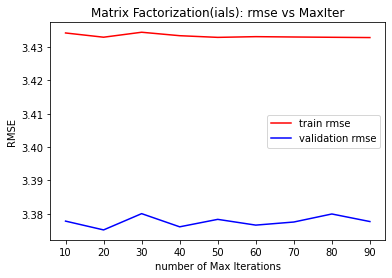

In [52]:
plt.plot(ials_iter,  ials_train_iter, color= 'r',label='train rmse' )
plt.plot(ials_iter,  ials_val_iter, color= 'b',label='validation rmse' )
plt.xlabel('number of Max Iterations')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs MaxIter')
plt.legend()
plt.show()

In [53]:
IALS_model = tc.ranking_factorization_recommender.create(train_data,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 2,\
                                                            regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 40 ,\
                                                            max_iterations = 60)

Preparing data set.

Data has 60607 observations with 10608 users and 211 items.

Data prepared in: 0.055226s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 60       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 176us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 27.108ms     | 3.75826                   |

| 1       | 45.924ms     | 3.44916                   |

| 2       | 76.605ms     | 3.40719                   |

| 3       | 99.974ms     | 3.40406                   |

| 4       | 118.38ms     | 3.40343                   |

| 5       | 138.607ms    | 3.40321                   |

| 6       | 160.65ms     | 3.40311                   |

| 7       | 182.311ms    | 3.40305                   |

| 8       | 205.755ms    | 3.403                     |

| 9       | 256.518ms    | 3.40298                   |

| 10      | 288.453ms    | 3.40298                   |

| 11      | 310.592ms    | 3.40298                   |

| 12      | 343.365ms    | 3.40298                   |

| 13      | 365.255ms    | 3.40298                   |

| 14      | 384.384ms    | 3.40298                   |

| 15      | 407.456ms    | 3.40298                   |

| 16      | 426.676ms    | 3.40298                   |

| 17      | 443.205ms    | 3.40298                   |

| 18      | 464.417ms    | 3.40298                   |

| 19      | 495.891ms    | 3.40298                   |

| 20      | 531.698ms    | 3.40298                   |

| 21      | 546.619ms    | 3.40298                   |

| 22      | 561.305ms    | 3.40298                   |

| 23      | 585.409ms    | 3.40298                   |

| 24      | 600.472ms    | 3.40298                   |

| 25      | 628.698ms    | 3.40298                   |

| 26      | 653.97ms     | 3.40298                   |

| 27      | 677.124ms    | 3.40298                   |

| 28      | 692.407ms    | 3.40297                   |

| 29      | 713.769ms    | 3.40297                   |

| 30      | 733.853ms    | 3.40297                   |

| 31      | 763.671ms    | 3.40297                   |

| 32      | 780.615ms    | 3.40297                   |

| 33      | 800.261ms    | 3.40297                   |

| 34      | 818.593ms    | 3.40297                   |

| 35      | 840.164ms    | 3.40297                   |

| 36      | 873.394ms    | 3.40297                   |

| 37      | 895.335ms    | 3.40297                   |

| 38      | 913.774ms    | 3.40297                   |

| 39      | 945.143ms    | 3.40297                   |

| 40      | 966.749ms    | 3.40297                   |

| 41      | 982.57ms     | 3.40297                   |

| 42      | 997.152ms    | 3.40297                   |

| 43      | 1.01s        | 3.40297                   |

| 44      | 1.03s        | 3.40297                   |

| 45      | 1.05s        | 3.40297                   |

| 46      | 1.07s        | 3.40297                   |

| 47      | 1.09s        | 3.40297                   |

| 48      | 1.11s        | 3.40297                   |

| 49      | 1.13s        | 3.40297                   |

| 50      | 1.16s        | 3.40297                   |

| 51      | 1.18s        | 3.40297                   |

| 52      | 1.20s        | 3.40297                   |

| 53      | 1.22s        | 3.40297                   |

| 54      | 1.25s        | 3.40296                   |

| 55      | 1.26s        | 3.40296                   |

| 56      | 1.28s        | 3.40296                   |

| 57      | 1.30s        | 3.40296                   |

| 58      | 1.31s        | 3.40296                   |

| 59      | 1.33s        | 3.40296                   |

| FINAL   | 1.33s        | 3.40296                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

In [54]:
IALS_evaluation = IALS_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

recommendations finished on 1000/8185 queries. users per second: 229885

recommendations finished on 2000/8185 queries. users per second: 294985

recommendations finished on 3000/8185 queries. users per second: 295334

recommendations finished on 4000/8185 queries. users per second: 290360

recommendations finished on 5000/8185 queries. users per second: 278211

recommendations finished on 6000/8185 queries. users per second: 289017

recommendations finished on 7000/8185 queries. users per second: 299312

recommendations finished on 8000/8185 queries. users per second: 247112

In [55]:
col_names =  ['cutoff', 'precision', 'recall'] 
IALS_results  = pd.DataFrame(columns = col_names)
IALS_results['cutoff'] = np.array(IALS_evaluation['precision_recall_overall']['cutoff'])
IALS_results['precision'] = np.array(IALS_evaluation['precision_recall_overall']['precision'])
IALS_results['recall'] = np.array(IALS_evaluation['precision_recall_overall']['recall'])

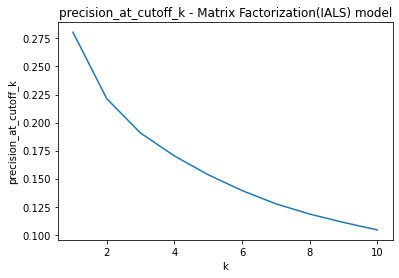

In [56]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('precision_at_cutoff_k - Matrix Factorization(IALS) model')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()